# Main SOGOS Float Processing

We start by downloading float data using the GO-BGC Toolbox. 
We will select floats for RFR training and run QC. 

- [Argo ERDDAP Data Server](http://www.argodatamgt.org/Access-to-data/ERDDAP-data-server)
- Code courtesy of [GO-BGC Toolbox](https://github.com/go-bgc/workshop-python/blob/main/GO_BGC_Workshop_Python_tutorial.ipynb) (Ethan Campbell 2021)

In [183]:
# Import packages
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import requests
import time
import os
import urllib3
import shutil
import plotly.graph_objs as go
import gsw

import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
from cmocean import cm as cmo
import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib.patches as patch

# pip install matplotlib-label-lines
from labellines import labelLine, labelLines
# Modules
import mod_main as sg
import mod_L3proc as gproc     # for L3 grid processing
import mod_DFproc as dfproc    # for dataframe processing
import mod_plot as sgplot  


# # Base filepath. Need for Argo GDAC function.
root = '../data/'
profile_dir = root + 'bgc-argo/'

In [98]:
# Open ship and glider track for later comparison and plotting.
# from mod_main import shipDF

# If you are rerunning figures, open previous QC float data:
# from mod_main import floatDF
# wmoids = pd.unique(floatDF.wmoid)

## 0. Set up float download functions to subset
- Code courtesy of GO-BGC Toolbox: <https://github.com/go-bgc/workshop-python/blob/main/GO_BGC_Workshop_Python_tutorial.ipynb>

In [112]:
# Function to download a single file (GO-BGC Toolbox)
def download_file(url_path,filename,save_to=None,overwrite=False,verbose=True):
    """ Downloads and saves a file from a given URL using HTTP protocol.

    Note: If '404 file not found' error returned, function will return without downloading anything.
    
    Arguments:
        url_path: root URL to download from including trailing slash ('/')
        filename: filename to download including suffix
        save_to: None (to download to root Google Drive GO-BGC directory)
                 or directory path
        overwrite: False to leave existing files in place
                   or True to overwrite existing files
        verbose: True to announce progress
                 or False to stay silent
    
    """
    urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

    if save_to is None:
      save_to = root #profile_dir  # EDITED HERE

    try:
      if filename in os.listdir(save_to):
          if not overwrite:
              if verbose: print('>>> File ' + filename + ' already exists. Leaving current version.')
              return
          else:
              if verbose: print('>>> File ' + filename + ' already exists. Overwriting with new version.')

      def get_func(url,stream=True):
          try:
              return requests.get(url,stream=stream,auth=None,verify=False)
          except requests.exceptions.ConnectionError as error_tag:
              print('Error connecting:',error_tag)
              time.sleep(1)
              return get_func(url,stream=stream)

      response = get_func(url_path + filename,stream=True)

      if response.status_code == 404:
          if verbose: print('>>> File ' + filename + ' returned 404 error during download.')
          return
      with open(save_to + filename,'wb') as out_file:
          shutil.copyfileobj(response.raw,out_file)
      del response
      if verbose: print('>>> Successfully downloaded ' + filename + '.')

    except:
      if verbose: print('>>> An error occurred while trying to download ' + filename + '.')

In [113]:
# Function to download and parse GDAC synthetic profile index file (GO-BGC Toolbox)
def argo_gdac(lat_range=None,lon_range=None,start_date=None,end_date=None,sensors=None,floats=None,
              overwrite_index=False,overwrite_profiles=False,skip_download=False,
              download_individual_profs=False,save_to=None,verbose=True):
  """ Downloads GDAC Sprof index file, then selects float profiles based on criteria.
      Either returns information on profiles and floats (if skip_download=True) or downloads them (if False).

      Arguments:
          lat_range: None, to select all latitudes
                     or [lower, upper] within -90 to 90 (selection is inclusive)
          lon_range: None, to select all longitudes
                     or [lower, upper] within either -180 to 180 or 0 to 360 (selection is inclusive)
                     NOTE: longitude range is allowed to cross -180/180 or 0/360
          start_date: None or datetime object
          end_date:   None or datetime object
          sensors: None, to select profiles with any combination of sensors
                   or string or list of strings to specify required sensors
                   > note that common options include PRES, TEMP, PSAL, DOXY, CHLA, BBP700,
                                                      PH_IN_SITU_TOTAL, and NITRATE
          floats: None, to select any floats matching other criteria
                  or int or list of ints specifying floats' WMOID numbers
          overwrite_index: False to keep existing downloaded GDAC index file, or True to download new index
          overwrite_profiles: False to keep existing downloaded profile files, or True to download new files
          skip_download: True to skip download and return: (, ,
                                                            )
                         or False to download those profiles
          download_individual_profs: False to download single Sprof file containing all profiles for each float
                                     or True to download individual profile files for each float
          save_to: None to download to Google Drive "/GO-BGC Workshop/Profiles" directory
                   or string to specify directory path for profile downloads
          verbose: True to announce progress, or False to stay silent

  """
  # Paths
  url_root = 'https://www.usgodae.org/ftp/outgoing/argo/'
  dac_url_root = url_root + 'dac/'
  index_filename = 'argo_synthetic-profile_index.txt'
  if save_to is None: save_to = root

  # Download GDAC synthetic profile index file
  download_file(url_root,index_filename,overwrite=overwrite_index)

  # Load index file into Pandas DataFrame
  gdac_index = pd.read_csv(root + index_filename,delimiter=',',header=8,parse_dates=['date','date_update'],
                          date_parser=lambda x: pd.to_datetime(x,format='%Y%m%d%H%M%S'))

  # Establish time and space criteria
  if lat_range is None:  lat_range = [-90.0,90.0]
  if lon_range is None:  lon_range = [-180.0,180.0]
  elif lon_range[0] > 180 or lon_range[1] > 180:
    if lon_range[0] > 180: lon_range[0] -= 360
    if lon_range[1] > 180: lon_range[1] -= 360
  if start_date is None: start_date = datetime(1900,1,1)
  if end_date is None:   end_date = datetime(2200,1,1)

  float_wmoid_regexp = r'[a-z]*/[0-9]*/profiles/[A-Z]*([0-9]*)_[0-9]*[A-Z]*.nc'
  gdac_index['wmoid'] = gdac_index['file'].str.extract(float_wmoid_regexp).astype(int)
  filepath_main_regexp = '([a-z]*/[0-9]*/)profiles/[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath_main'] = gdac_index['file'].str.extract(filepath_main_regexp)
  filepath_regexp = '([a-z]*/[0-9]*/profiles/)[A-Z]*[0-9]*_[0-9]*[A-Z]*.nc'
  gdac_index['filepath'] = gdac_index['file'].str.extract(filepath_regexp)
  filename_regexp = '[a-z]*/[0-9]*/profiles/([A-Z]*[0-9]*_[0-9]*[A-Z]*.nc)'
  gdac_index['filename'] = gdac_index['file'].str.extract(filename_regexp)

  # Subset profiles based on time and space criteria
  gdac_index_subset = gdac_index.loc[np.logical_and.reduce([gdac_index['latitude'] >= lat_range[0],
                                                            gdac_index['latitude'] <= lat_range[1],
                                                            gdac_index['date'] >= start_date,
                                                            gdac_index['date'] <= end_date]),:]
  if lon_range[1] >= lon_range[0]:    # range does not cross -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_and(gdac_index_subset['longitude'] >= lon_range[0],
                                                             gdac_index_subset['longitude'] <= lon_range[1])]
  elif lon_range[1] < lon_range[0]:   # range crosses -180/180 or 0/360
    gdac_index_subset = gdac_index_subset.loc[np.logical_or(gdac_index_subset['longitude'] >= lon_range[0],
                                                            gdac_index_subset['longitude'] <= lon_range[1])]

  # If requested, subset profiles using float WMOID criteria
  if floats is not None:
    if type(floats) is not list: floats = [floats]
    gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['wmoid'].isin(floats),:]

  # If requested, subset profiles using sensor criteria
  if sensors is not None:
    if type(sensors) is not list: sensors = [sensors]
    for sensor in sensors:
      gdac_index_subset = gdac_index_subset.loc[gdac_index_subset['parameters'].str.contains(sensor),:]

  # Examine subsetted profiles
  wmoids = gdac_index_subset['wmoid'].unique()
  wmoid_filepaths = gdac_index_subset['filepath_main'].unique()

  # Just return list of floats and DataFrame with subset of index file, or download each profile
  if not skip_download:
    downloaded_filenames = []
    if download_individual_profs:
      for p_idx in gdac_index_subset.index:
        download_file(dac_url_root + gdac_index_subset.loc[p_idx]['filepath'],
                      gdac_index_subset.loc[p_idx]['filename'],
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(gdac_index_subset.loc[p_idx]['filename'])
    else:
      for f_idx, wmoid_filepath in enumerate(wmoid_filepaths):
        download_file(dac_url_root + wmoid_filepath,str(wmoids[f_idx]) + '_Sprof.nc',
                      save_to=save_to,overwrite=overwrite_profiles,verbose=verbose)
        downloaded_filenames.append(str(wmoids[f_idx]) + '_Sprof.nc')
    return wmoids, gdac_index_subset, downloaded_filenames
  else:
    return wmoids, gdac_index_subset

### Download float data of interest

In [114]:
# Get all floats from chosen period
lat_bounds = [-65,-45]  # used to be -70 to -30
lon_bounds = [5,65]    # used to be 10, 60

# Try using more time buffer, 2 years. 
start_yd = datetime(2017,4,20) # datetime(2019,4,30)  # yd 120
end_yd = datetime(2021,7,30) # datetime(2019,7,19)  # yd 200

# download
wmoids, gdac_index, downloaded_filenames = argo_gdac(lat_range=lat_bounds,lon_range=lon_bounds,
                               start_date=start_yd,end_date=end_yd,
                               sensors=None,floats=None,
                               overwrite_index=True,overwrite_profiles=True,  # over profiles change to true
                               skip_download=False,download_individual_profs=False,  
                               save_to=profile_dir,verbose=True)

# dont download, just get wmoids
# wmoids, gdac_index = argo_gdac(lat_range=lat_bounds,lon_range=lon_bounds,
#                                start_date=start_yd,end_date=end_yd,
#                                sensors=None,floats=None,
#                                overwrite_index=True,overwrite_profiles=False,
#                                skip_download=True,download_individual_profs=False,
#                                save_to=profile_dir,verbose=True)

# download specific float #5906030 
# wmoids, gdac_index, downloaded_filenames \
#                    = argo_gdac(lat_range=None,lon_range=None,
#                                start_date=None,end_date=None,
#                                sensors=None,floats=5906030,
#                                overwrite_index=True,overwrite_profiles=False,
#                                skip_download=False,download_individual_profs=False,
#                                save_to=profile_dir,verbose=True)


>>> File argo_synthetic-profile_index.txt already exists. Overwriting with new version.
>>> Successfully downloaded argo_synthetic-profile_index.txt.
>>> Successfully downloaded 5904469_Sprof.nc.
>>> Successfully downloaded 5904471_Sprof.nc.
>>> Successfully downloaded 5904658_Sprof.nc.
>>> Successfully downloaded 5904659_Sprof.nc.
>>> Successfully downloaded 5904845_Sprof.nc.
>>> Successfully downloaded 5904847_Sprof.nc.
>>> Successfully downloaded 5904854_Sprof.nc.
>>> Successfully downloaded 5905135_Sprof.nc.
>>> Successfully downloaded 5905366_Sprof.nc.
>>> Successfully downloaded 5905368_Sprof.nc.
>>> Successfully downloaded 5905369_Sprof.nc.
>>> Successfully downloaded 5905382_Sprof.nc.
>>> Successfully downloaded 5905996_Sprof.nc.
>>> Successfully downloaded 5906007_Sprof.nc.
>>> Successfully downloaded 5906008_Sprof.nc.
>>> Successfully downloaded 5906030_Sprof.nc.
>>> Successfully downloaded 5906031_Sprof.nc.
>>> Successfully downloaded 5906032_Sprof.nc.
>>> Successfully downl

- Note that we start with a large space and time window. Floats are selected individually (see diagnostic... sogos_float_processing.ipynb)

In [115]:
# Create Float dictionary 
wmoids=np.sort(wmoids)
DSdict = {}
for filename in os.listdir(profile_dir):
    if filename.endswith(".nc"):
        fp = profile_dir + filename
        single_dataset = xr.open_dataset(fp, decode_times=False)
        DSdict[filename[0:7]] = single_dataset
# DSdict['5906030']
wmoids

array([2902295, 2902296, 2902297, 2902298, 2902299, 3901999, 5903248,
       5904469, 5904471, 5904658, 5904659, 5904845, 5904847, 5904854,
       5905135, 5905366, 5905368, 5905369, 5905382, 5905996, 5906007,
       5906008, 5906030, 5906031, 5906032, 5906034, 5906206, 5906207,
       5906209, 5906210, 5906211, 6900791, 6900793, 6901585, 6901688,
       6902742, 6902905, 6903026, 6903183, 6903777, 7900907])

In [116]:
wmoids_full = wmoids

# 1. Float DataFrame Processing

In [117]:
# Set up variables to store
dvars = ['wmoid','profid','yearday','lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'temperature','salinity', 'sigma0', 'spice'] #, 'bbp700','pH']
qcvars = ['juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc'] #, 'pH_qc','bbp700_qc']

- Need to add profile unique ID's for splitting by profile later in RF


In [118]:
# Function to build a dataframe from a single float dataset
# Set up variables to store
# dvars = ['wmoid','profid','yearday','lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'temperature','salinity', 'sigma0', 'spice', 'bbp700','pH']
# qcvars = ['juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc', 'pH_qc', 'bbp700_qc'

dvars = ['wmoid','profid','yearday','lat','lon','pressure','CT', 'SA','oxygen','nitrate', 'temperature','salinity', 'sigma0', 'spice'] #, 'bbp700','pH']
qcvars = ['juld_qc', 'position_qc', 'pressure_qc', 'temperature_qc', 'salinity_qc', 'oxygen_qc', 'nitrate_qc'] #, 'pH_qc','bbp700_qc']

def make_float_df(wmo, floatDSdict):
        """
        Return dataframe from a single float dataset
        @param:
                wmo (int)
                floatDSdict (dict): dictionary of float datasets
        """
        temp = floatDSdict[str(wmo)]
        float_df = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                         'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                        'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                        'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
        dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
        float_df['yearday'] = sg.datetime2ytd(dtimes)
        float_df['wmoid'] = np.repeat(wmo, len(float_df))


        # need to get the profile number from the index
        # create a 10-digit unique id so easy to sort later
        prof = float_df.index.get_level_values(0)
        prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
        float_df['profid'] = [str(wmo)+tag for tag in prof]


        qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
            'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC'] #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC']
        for key in qc_keys:  #qc flags are not stored as ints so we can convert
                newlist = []
                for qc in float_df[key]:
                        if str(qc)[2] == 'n': newlist.append('NaN')
                        else: newlist.append(str(qc)[2])
                float_df[key] = newlist
        
        float_df.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
                        'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
                        'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate'}, inplace=True)
                        # 'PH_IN_SITU_TOTAL_ADJUSTED': 'pH', 'BBP700_ADJUSTED': 'bbp700'
        float_df.rename(columns={'JULD_QC': 'juld_qc', 'POSITION_QC': 'position_qc', 
                        'PRES_ADJUSTED_QC': 'pressure_qc', 'TEMP_ADJUSTED_QC': 'temperature_qc','PSAL_ADJUSTED_QC': 'salinity_qc',
                        'DOXY_ADJUSTED_QC': 'oxygen_qc', 'NITRATE_ADJUSTED_QC': 'nitrate_qc'}, inplace=True) 
                        # 'PH_IN_SITU_TOTAL_ADJUSTED_QC': 'pH_qc','BBP700_ADJUSTED_QC': 'bbp700_qc'

        float_df['CT'] = gsw.CT_from_t(float_df['salinity'], float_df['temperature'], float_df['pressure'])
        float_df['SA']= gsw.SA_from_SP(float_df['salinity'],float_df['pressure'],float_df['lon'],float_df['lat'])

        # # Add training variables Sigma0 and Spice as desired
        float_df['sigma0'] = gsw.sigma0(float_df.SA.values, float_df.CT.values)
        float_df['spice'] = gsw.spiciness0(float_df["SA"].values, float_df["CT"].values)

        # Add oxygen saturation and drho/dz
        float_df = float_df[dvars + qcvars]

        return float_df


### Get full float 5906030 MLD

In [12]:
wmo = 5906030
temp = DSdict[str(wmo)]
float6030 = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                    'DOXY_ADJUSTED','NITRATE_ADJUSTED', # , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC']].to_dataframe() #'BBP700_ADJUSTED_QC' #, 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
dtimes = pd.to_datetime(float6030.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
float6030['yearday'] = sg.datetime2ytd(dtimes)
float6030['wmoid'] = np.repeat(wmo, len(float6030))

# need to get the profile number from the index
# create a 10-digit unique id so easy to sort later
prof = float6030.index.get_level_values(0)
prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
float6030['profid'] = [str(wmo)+tag for tag in prof]



float6030.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
                'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
                'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate'}, inplace=True)
float6030['CT'] = gsw.CT_from_t(float6030['salinity'], float6030['temperature'], float6030['pressure'])
float6030['SA']= gsw.SA_from_SP(float6030['salinity'],float6030['pressure'],float6030['lon'],float6030['lat'])

# # Add training variables Sigma0 and Spice as desired
float6030['sigma0'] = gsw.sigma0(float6030.SA.values, float6030.CT.values)
float6030['spice'] = gsw.spiciness0(float6030["SA"].values, float6030["CT"].values)



In [13]:
dav_float, blank = dfproc.make_diveav(float6030, thresh=0.025, mld_lim=[5,15])
# dav_float = dav_float[dav_float.yearday<210]
dav_float

number of profiles with no 10m data:  0
approx # of obs within profile that were averaged for final mlp:  13.24698795180723
number of nan mlds even where 10m exists:  1


/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/RandomForest_SG/scripts/mod_DFproc.py:163: RuntimeWarning: Mean of empty slice
  dens10m = np.nanmean(temp10.sigma0.values)


,profid,yearday,lat,lon,mld
0,5906030000,120.374294,-51.355,30.208,110.387154
1,5906030001,125.159699,-51.074,32.828,99.488426
2,5906030002,130.068877,-51.796,31.632,89.316162
3,5906030003,135.173252,-52.452,31.764,84.632133
4,5906030004,140.063449,-51.856,33.445,72.162811
...,...,...,...,...,...
161,5906030161,1705.302280,-46.845,104.700,267.876923
162,5906030162,1715.673252,-47.040,106.254,218.220612
163,5906030163,1725.990336,-46.642,109.259,292.143188
164,5906030164,1736.343542,-47.493,110.733,182.868744


In [14]:
# To save for the first time
save = False
if save:
    dav_float.to_csv('../data/bgc-argo/dav_full6030_noqc.csv')

### Make full SOGOS float just for plotting (OUTDATED Apr 2024)

In [131]:
# Single time make sogos float df
def make_sogos_df(wmo, sogos_dataset):
        """
        Return dataframe from a single float dataset
        @param:
                wmo (int)
                floatDSdict (dict): dictionary of float datasets
        """
        temp= sogos_dataset
        float_df = temp[['JULD','LATITUDE', 'LONGITUDE','PRES_ADJUSTED','TEMP_ADJUSTED','PSAL_ADJUSTED',
                         'DOXY_ADJUSTED','NITRATE_ADJUSTED' , 'PH_IN_SITU_TOTAL_ADJUSTED','BBP700_ADJUSTED', 
                         'CHLA_ADJUSTED',
                        'JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC','PSAL_ADJUSTED_QC', 
                        'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC', 'BBP700_ADJUSTED_QC' , 'PH_IN_SITU_TOTAL_ADJUSTED_QC',
                        'CHLA_ADJUSTED_QC']].to_dataframe()
        dtimes = pd.to_datetime(float_df.JULD.values, unit='D', origin=pd.Timestamp('1950-01-01'))
        float_df['yearday'] = sg.datetime2ytd(dtimes)
        float_df['wmoid'] = np.repeat(wmo, len(float_df))


        # need to get the profile number from the index
        # create a 10-digit unique id so easy to sort later
        prof = float_df.index.get_level_values(0)
        prof = prof.astype(str); prof = [tag.zfill(3) for tag in prof]
        float_df['profid'] = [str(wmo)+tag for tag in prof]


        qc_keys = ['JULD_QC', 'POSITION_QC', 'PRES_ADJUSTED_QC', 'TEMP_ADJUSTED_QC', 'PSAL_ADJUSTED_QC',
            'DOXY_ADJUSTED_QC', 'NITRATE_ADJUSTED_QC', 'PH_IN_SITU_TOTAL_ADJUSTED_QC', 'BBP700_ADJUSTED_QC', 'CHLA_ADJUSTED_QC']
        for key in qc_keys:  #qc flags are not stored as ints so we can convert
                newlist = []
                for qc in float_df[key]:
                        if str(qc)[2] == 'n': newlist.append('NaN')
                        else: newlist.append(str(qc)[2])
                float_df[key] = newlist
        
        float_df.rename(columns={'LATITUDE':'lat','LONGITUDE':'lon',
                        'PRES_ADJUSTED': 'pressure', 'TEMP_ADJUSTED': 'temperature', 'PSAL_ADJUSTED': 'salinity',
                        'DOXY_ADJUSTED': 'oxygen', 'NITRATE_ADJUSTED':'nitrate',
                        'PH_IN_SITU_TOTAL_ADJUSTED': 'pH', 'BBP700_ADJUSTED': 'bbp700',
                        'CHLA_ADJUSTED': 'chl'}, inplace=True)
        float_df.rename(columns={'JULD_QC': 'juld_qc', 'POSITION_QC': 'position_qc', 
                        'PRES_ADJUSTED_QC': 'pressure_qc', 'TEMP_ADJUSTED_QC': 'temperature_qc','PSAL_ADJUSTED_QC': 'salinity_qc',
                        'DOXY_ADJUSTED_QC': 'oxygen_qc', 'NITRATE_ADJUSTED_QC': 'nitrate_qc',
                        'PH_IN_SITU_TOTAL_ADJUSTED_QC': 'pH_qc','BBP700_ADJUSTED_QC': 'bbp700_qc',
                        'CHLA_ADJUSTED_QC':'chl_qc'}, inplace=True) 

        float_df['CT'] = gsw.CT_from_t(float_df['salinity'], float_df['temperature'], float_df['pressure'])
        float_df['SA']= gsw.SA_from_SP(float_df['salinity'],float_df['pressure'],float_df['lon'],float_df['lat'])

        # # Add training variables Sigma0 and Spice as desired
        float_df['sigma0'] = gsw.sigma0(float_df.SA.values, float_df.CT.values)
        float_df['spice'] = gsw.spiciness0(float_df["SA"].values, float_df["CT"].values)

        # Add oxygen saturation and drho/dz
        float_df = float_df[dvars + qcvars]

        return float_df


In [132]:
ds_sogos = DSdict['5906030']
df_sogos = make_sogos_df(5906030, ds_sogos)
# df_sogos.yearday.unique()

array([ 120.37429399,  125.15969908,  130.06887732,  135.17325232,
        140.06344908,  145.18083334,  150.05370371,  155.18145834,
        160.07099537,  165.17320602,  170.07219908,  175.18189815,
        180.07158565,  185.1832176 ,  190.07039352,  195.18109954,
        205.57494215,  215.95613429,  226.33418982,  236.63769678,
        247.11646991,  257.48285881,  267.78908567,  278.14074074,
        288.46949075,  298.83622688,  309.15118056,  319.47401622,
        329.86125003,  340.25081019,  350.54623844,  360.8597454 ,
        371.16269676,  381.50637733,  391.85553243,  402.14082176,
        412.60065974,  422.90336808,  433.23163195,  443.57451391,
        453.88497688,  464.31782408,  474.66969909,  485.03662037,
        495.40938659,  505.74084493,  516.11309028,  526.42901622,
        536.78240743,  547.08822917,  557.41126159,  567.76005789,
        578.11136574,  588.42766205,  598.79807873,  609.12418982,
        619.49555557,  629.89106484,  640.19054399,  650.54594

In [137]:
df_sogos

wmoid      profid      yearday     lat      lon  \
N_PROF N_LEVELS                                                      
0      0         5906030  5906030000   120.374294 -51.355   30.208   
       1         5906030  5906030000   120.374294 -51.355   30.208   
       2         5906030  5906030000   120.374294 -51.355   30.208   
       3         5906030  5906030000   120.374294 -51.355   30.208   
       4         5906030  5906030000   120.374294 -51.355   30.208   
...                  ...         ...          ...     ...      ...   
162    554       5906030  5906030162  1715.673252 -47.040  106.254   
       555       5906030  5906030162  1715.673252 -47.040  106.254   
       556       5906030  5906030162  1715.673252 -47.040  106.254   
       557       5906030  5906030162  1715.673252 -47.040  106.254   
       558       5906030  5906030162  1715.673252 -47.040  106.254   

                    pressure        CT         SA      oxygen    nitrate  ...  \
N_PROF N_LEVELS                                                           ...   
0      0            4.280000  3.641656  34.001309         NaN        NaN  ...   
       1            6.080000  3.641551  34.000266         NaN        NaN  ...   
       2            8.180000  3.641407  34.001243         NaN        NaN  ...   
       3           10.280001  3.641282  34.000216         NaN        NaN  ...   
       4           10.990001  3.641234  34.000570  326.896942  24.232952  ...   
...                      ...       ...        ...         ...        ...  ...   
162    554       1699.510010  2.373796  34.861644  175.912186  32.058662  ...   
       555       1798.969971  2.320682  34.876801  178.026093  31.683699  ...   
       556       1899.310059  2.188106  34.894839  180.653244  31.419233  ...   
       557               NaN       NaN        NaN         NaN        NaN  ...   
       558               NaN       NaN        NaN         NaN        NaN  ...   

                  salinity     sigma0     spice  juld_qc position_qc  \
N_PROF N_LEVELS                                                        
0      0         33.839714  26.901720 -0.505345        1           1   
       1         33.838696  26.900904 -0.506094        1           1   
       2         33.839691  26.901692 -0.505418        1           1   
       3         33.838692  26.900891 -0.506158        1           1   
       4         33.839050  26.901176 -0.505913        1           1   
...                    ...        ...       ...      ...         ...   
162    554       34.692204  27.699464 -0.026514        1           1   
       555       34.707100  27.715981 -0.020833        1           1   
       556       34.724903  27.741320 -0.020422        1           1   
       557             NaN        NaN       NaN        1           1   
       558             NaN        NaN       NaN        1           1   

                pressure_qc temperature_qc salinity_qc oxygen_qc nitrate_qc  
N_PROF N_LEVELS                                                              
0      0                  1              1           1       NaN        NaN  
       1                  1              1           1       NaN        NaN  
       2                  1              1           1       NaN        NaN  
       3                  1              1           1       NaN        NaN  
       4                  1              8           8         1          1  
...                     ...            ...         ...       ...        ...  
162    554                1              1           1         1          1  
       555                1              1           1         1          1  
       556                1              1           1         1          1  
       557              NaN            NaN         NaN       NaN        NaN  
       558              NaN            NaN         NaN       NaN        NaN  

[91117 rows x 21 columns]

In [144]:
df_sogos[df_sogos.profid == '5906030002'].nitrate_qc.unique()

array(['NaN', '3'], dtype=object)

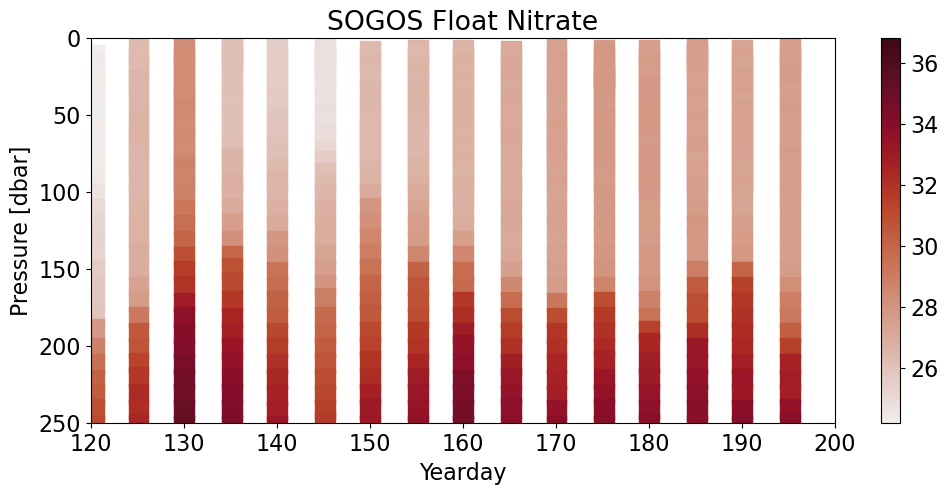

In [91]:
fig = plt.figure(figsize=(12,5))

dat = df_sogos[(df_sogos.yearday>120) & (df_sogos.yearday<210)]
plt.scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.amp, s=200, marker='s')
ax=plt.gca()
ax.invert_yaxis()
ax.set_title('SOGOS Float Nitrate')
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
ax.set_ylim([250, 0])
ax.set_xlim([120,200])
plt.colorbar()


In [131]:
# df_sogos.to_csv('../working-vars/go-bgc/sogos_float_0928.csv')

## Make full float dictionaries and DFs

In [119]:
# Create float dictionary with valid nitrate data
DFdict = {}
for wmo in wmoids:
    try: 
        float_df = make_float_df(wmo, DSdict)
        print(str(wmo) + ' added to dataframe dictionary')
    except:
        print(str(wmo) + ' missing data fields')
    else: DFdict[str(wmo)] = float_df

# Create combined floats dataframe
argo_df = pd.DataFrame()
for DF in DFdict:
    argo_df = pd.concat([argo_df, DFdict[DF]])

2902295 missing data fields
2902296 missing data fields
2902297 missing data fields
2902298 missing data fields
2902299 missing data fields
3901999 missing data fields
5903248 missing data fields
5904469 added to dataframe dictionary
5904471 added to dataframe dictionary
5904658 added to dataframe dictionary
5904659 added to dataframe dictionary
5904845 added to dataframe dictionary
5904847 added to dataframe dictionary
5904854 added to dataframe dictionary
5905135 added to dataframe dictionary
5905366 added to dataframe dictionary
5905368 added to dataframe dictionary
5905369 added to dataframe dictionary
5905382 missing data fields
5905996 added to dataframe dictionary
5906007 added to dataframe dictionary
5906008 added to dataframe dictionary
5906030 added to dataframe dictionary
5906031 added to dataframe dictionary
5906032 added to dataframe dictionary
5906034 added to dataframe dictionary
5906206 added to dataframe dictionary
5906207 added to dataframe dictionary
5906209 added to

- From here, you can use

            DSdict                  dataset dictionary
            DFdict                  dataframe dictionary
            argo_df                 no qc, just combined argo dataframes
            argo_data               qc'd argo data as Pandas dataframe
            wmo_qc                  list of valid floats to use after QC
            wmo_drop                list of float wmo's dropped during QC
            

## 1.1 Data QC and Spatial/Time Bounds

In [120]:
# Initial Range Drop
argo_data = argo_df.copy()

# Adjust data to bounds
argo_data = argo_data[argo_data['pressure'] <1000]
argo_data = argo_data[(argo_data['lat'] > -60) & (argo_data['lat'] < -45)]
argo_data = argo_data[(argo_data['lon'] > 5) & (argo_data['lon'] < 65)]

# cut off dates to two year before and after deployment
argo_data = argo_data[(argo_data['yearday'] > (120-365*2)) & (argo_data['yearday'] < (200+365*2))]
argo_data.describe()

,wmoid,yearday,lat,lon,pressure,CT,SA,oxygen,nitrate,temperature,salinity,sigma0,spice
count,5.084100e+05,508410.000000,508410.000000,508410.000000,508410.000000,506496.000000,506496.000000,124516.000000,50219.000000,507660.000000,506496.000000,506496.000000,506496.000000
mean,5.905472e+06,360.134549,-52.314141,36.345895,473.830109,2.300244,34.535432,230.753418,29.960533,2.324866,34.369038,27.433639,-0.249502
std,6.175289e+02,347.423519,4.321859,17.672082,286.770966,1.445028,0.298988,58.269371,4.288485,1.442455,0.296218,0.313104,0.206615
min,5.904469e+06,-603.853947,-59.999000,5.029000,2.120000,-1.856310,33.766927,163.400513,11.140358,-1.860000,33.605274,25.982729,-1.011093
25%,5.904847e+06,164.442222,-56.531000,21.168000,222.199997,1.704332,34.310413,183.422989,26.834473,1.729000,34.146919,27.217222,-0.337314
50%,5.905996e+06,402.853657,-51.643000,36.650000,462.339996,2.203693,34.594166,205.143005,30.270752,2.238000,34.427673,27.491269,-0.199164
75%,5.906030e+06,626.121840,-48.603000,51.726000,722.469971,2.732570,34.825497,288.034302,33.982044,2.767000,34.656075,27.694847,-0.101091
max,5.906211e+06,927.803403,-45.016000,64.896000,999.989990,10.949378,34.923836,371.921844,36.812965,10.964000,34.752781,27.852475,1.211068


- Flag meanings are here: (https://argo.ucsd.edu/data/how-to-use-argo-files/)

### sogos float

In [13]:
# df_sg = df_sogos.copy()
# df_sogos = df_sg.copy()
df_sogos = df_sogos[df_sogos['yearday']<210]

NameError: name 'df_sogos' is not defined

In [105]:
df_sogos.yearday.unique()

array([120.37429399, 125.15969908, 130.06887732, 135.17325232,
       140.06344908, 145.18083334, 150.05370371, 155.18145834,
       160.07099537, 165.17320602, 170.07219908, 175.18189815,
       180.07158565, 185.1832176 , 190.07039352, 195.18109954,
       205.57494215])

In [100]:
df_sogos

,N_PROF,N_LEVELS,wmoid,profid,yearday,lat,lon,pressure,CT,SA,...,salinity,sigma0,spice,juld_qc,position_qc,pressure_qc,temperature_qc,salinity_qc,oxygen_qc,nitrate_qc
0,0,0,5906030,5906030000,120.374294,-51.355,30.208,4.280000,3.641656,34.001309,...,33.839714,26.901720,-0.505345,1,1,1,1,1,NaN,NaN
1,0,1,5906030,5906030000,120.374294,-51.355,30.208,6.080000,3.641551,34.000266,...,33.838696,26.900904,-0.506094,1,1,1,1,1,NaN,NaN
2,0,2,5906030,5906030000,120.374294,-51.355,30.208,8.180000,3.641407,34.001243,...,33.839691,26.901692,-0.505418,1,1,1,1,1,NaN,NaN
3,0,3,5906030,5906030000,120.374294,-51.355,30.208,10.280001,3.641282,34.000216,...,33.838692,26.900891,-0.506158,1,1,1,1,1,NaN,NaN
4,0,4,5906030,5906030000,120.374294,-51.355,30.208,10.990001,3.641234,34.000570,...,33.839050,26.901176,-0.505913,1,1,1,8,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9360,16,551,5906030,5906030016,205.574942,-52.475,38.640,1400.300049,1.812177,34.919077,...,34.748810,27.790599,-0.036933,1,1,1,1,1,1,1
9361,16,552,5906030,5906030016,205.574942,-52.475,38.640,1500.520020,1.748418,34.928293,...,34.757820,27.802856,-0.035969,1,1,1,1,1,1,1
9362,16,553,5906030,5906030016,205.574942,-52.475,38.640,1600.150024,1.656917,34.925910,...,34.755318,27.807912,-0.045436,1,1,1,1,1,1,1
9363,16,554,5906030,5906030016,205.574942,-52.475,38.640,1698.810059,1.557405,34.920717,...,34.750027,27.811212,-0.057423,1,1,1,1,1,1,1


In [124]:
dav_float = dfproc.make_diveav(df_sogos, thresh=0.006)

number of profiles with no 10m data:  0
approx # of obs within profile that were averaged for final mlp:  3.823529411764706
number of nan mlds even where 10m exists:  1


In [123]:
dav_float

(        profid     yearday     lat     lon         mld
 0   5906030000  120.374294 -51.355  30.208  109.180000
 1   5906030001  125.159699 -51.074  32.828  130.976013
 2   5906030002  130.068877 -51.796  31.632   91.334442
 3   5906030003  135.173252 -52.452  31.764   82.325722
 4   5906030004  140.063449 -51.856  33.445   73.688004
 5   5906030005  145.180833 -51.417  34.669   78.059998
 6   5906030006  150.053704 -51.576  35.332  104.769997
 7   5906030007  155.181458 -52.204  35.413  110.140007
 8   5906030008  160.070995 -52.743  34.407  127.449997
 9   5906030009  165.173206 -53.360  35.171  158.350006
 10  5906030010  170.072199 -53.617  36.474  162.873337
 11  5906030011  175.181898 -53.408  37.065  158.130005
 12  5906030012  180.071586 -52.997  36.872  160.915985
 13  5906030013  185.183218 -52.675  36.722  137.943085
 14  5906030014  190.070394 -52.394  37.194  138.389999
 15  5906030015  195.181100 -52.223  37.785  171.312851
 16  5906030016  205.574942 -52.475  38.640  170

In [106]:
X = len(df_sogos)

for var in ['juld_qc','position_qc','pressure_qc','temperature_qc','salinity_qc']: #,'oxygen_qc','nitrate_qc']:
    df_sogos = df_sogos[(df_sogos[var] == '1') | (df_sogos[var] == '2')| (df_sogos[var] == '8')]
    #qc flag meanings           1: good data, 2: probably good data, 8: interpolated value
    
    print('after ' + var)
    print('\t' + str(len(df_sogos)) + ' obs left   ' + ' \t' +str(X-len(df_sogos)) + ' dropped'); 
    len(df_sogos)



after juld_qc
	9503 obs left    	0 dropped
after position_qc
	9503 obs left    	0 dropped
after pressure_qc
	9373 obs left    	130 dropped
after temperature_qc
	9365 obs left    	138 dropped
after salinity_qc
	9365 obs left    	138 dropped


In [110]:
df_sogos.columns = df_sogos.columns.droplevel(0)

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

In [98]:
df_sogos.to_csv('../working-vars/go-bgc/dav_sgfloat_0201.csv')

### Back to main argo_data

## QC drop

In [121]:
# Additional variable QC drop
argo_qc = argo_data.copy()
print(str(len(argo_qc)) + ' obs before QC')
X = len(argo_qc)

for var in [x for x in qcvars if x != "pH_qc"]:
    argo_qc = argo_qc[(argo_qc[var] == '1') | (argo_qc[var] == '2')| (argo_qc[var] == '8')]
    #qc flag meanings           1: good data, 2: probably good data, 8: interpolated value
    
    print('after ' + var)
    print('\t' + str(len(argo_qc)) + ' obs left   ' + ' \t' +str(X-len(argo_qc)) + ' dropped'); 
    X = len(argo_qc)

print('Note no QC drop on pH to preserve nitrate data from SOGOS float')
print('Keep pH as a field for now, but will not use')

argo_qc.describe()

508410 obs before QC
after juld_qc
	508410 obs left    	0 dropped
after position_qc
	508410 obs left    	0 dropped
after pressure_qc
	508410 obs left    	0 dropped
after temperature_qc
	507660 obs left    	750 dropped
after salinity_qc
	506493 obs left    	1167 dropped
after oxygen_qc
	123967 obs left    	382526 dropped
after nitrate_qc
	49964 obs left    	74003 dropped
Note no QC drop on pH to preserve nitrate data from SOGOS float
Keep pH as a field for now, but will not use


,wmoid,yearday,lat,lon,pressure,CT,SA,oxygen,nitrate,temperature,salinity,sigma0,spice
count,4.996400e+04,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000,49964.000000
mean,5.905522e+06,400.083977,-52.579963,36.196153,280.237823,2.292904,34.363543,257.240204,29.956150,2.304260,34.198784,27.290397,-0.363443
std,6.091624e+02,332.013062,4.239642,17.345412,253.406860,1.796433,0.313725,61.559242,4.289633,1.796045,0.310451,0.336383,0.240155
min,5.904469e+06,-603.853947,-59.999000,5.065000,4.020000,-1.856310,33.767102,163.400513,11.140358,-1.860000,33.605450,25.983025,-1.011093
25%,5.904847e+06,210.733345,-56.747000,21.723000,82.209999,1.361932,34.073475,192.544716,26.835517,1.367323,33.911842,27.063252,-0.568297
50%,5.905996e+06,438.336123,-51.938000,36.650000,211.900002,2.112287,34.306249,260.331192,30.263911,2.134000,34.142717,27.276257,-0.333664
75%,5.906031e+06,652.254873,-48.965000,50.173000,360.989990,3.020815,34.657652,317.580627,33.978909,3.032010,34.489994,27.567037,-0.183634
max,5.906211e+06,927.803403,-45.016000,64.896000,999.989990,10.842103,34.923669,371.921844,36.472710,10.854000,34.752590,27.852475,1.201986


In [123]:
len(argo_qc)

49964

ValueError: min() arg is an empty sequence

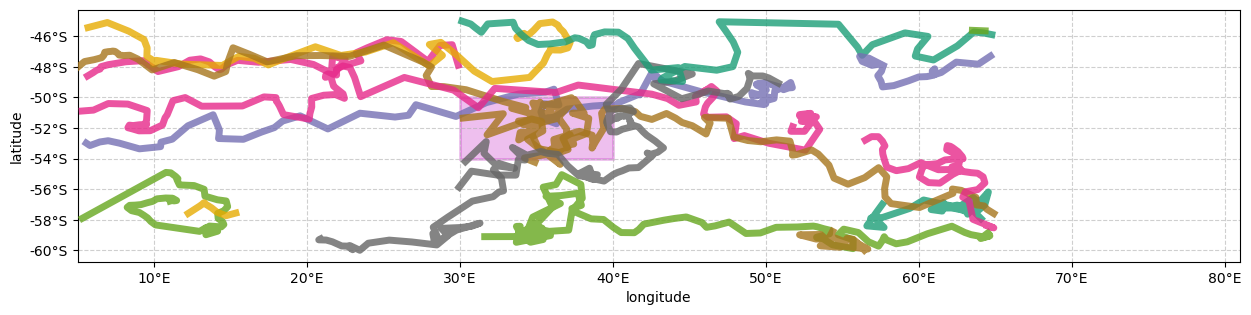

In [129]:
# Reference: Before dropping additional floats
# Set up WMO color palette
pal = sns.color_palette("Dark2", 50)
wmo_colors = dict.fromkeys(wmoids)
for i, wmo in enumerate(wmoids):
    wmo_colors[wmo] = pal[i]
    
fig = plt.figure(figsize=(15,10))
ax=plt.gca()

for wmo in wmoids:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.8, linewidth=5, label=str(wmo)[3:], zorder=3)
    
# plt.title('SOGOS BGC-Argo Matchups (2018-2020)')
rect = patch.Rectangle((30,-54),10,4, fill=True, color="m", alpha=0.25,linewidth=2, zorder=1)

# ax.legend()
ax.add_patch(rect)
ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)

ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)

# labelLines(lins) # , align=False, fontsize=18)


# plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)

## want to restrict

In [130]:
# Methods
def print_bounds(DF):
    # print('Bounds of data: \n')
    print('Dates: \t\t' + str(sg.ytd2datetime(DF.yearday.min())) + ' to ' + str(sg.ytd2datetime(DF.yearday.max())))
    print('Latitude:\t' + str(DF.lat.min()) + ' to ' + str(DF.lat.max()))
    print('Longitude:\t' + str(DF.lon.min()) + ' to ' + str(DF.lon.max()))
    
def restrict_DF(data, start_yd, end_yd, lat1, lat2, lon1, lon2):
    data = data[(data.lat > lat1) & (data.lat < lat2)]
    data = data[(data.lon > lon1 ) & (data.lon <lon2)]
    data = data[(data.yearday > start_yd) & (data.yearday < end_yd)]
    return data


In [131]:
PF = pd.read_csv('../data/ACC_fronts/PF.csv', header=None)
SIF = pd.read_csv('../data/ACC_fronts/SIF.csv', header=None)
for csv in [PF, SIF]:
    csv.columns = ['lon', 'lat']

In [184]:
# Restrict the data to Antarctic Southern Zone (ASZ) region
argo_qc = dfproc.between_fronts(argo_qc, PF, SIF, buffers=[0.5,0.5])
# ship_qc = dfproc.between_fronts(shipDF, PF, SIF, buffers=[0.5,0.5])

In [185]:
argo_qc

wmoid      profid     yearday     lat     lon    pressure  \
N_PROF N_LEVELS                                                                
85     3         5904469  5904469085 -603.853947 -54.200  30.351    7.530000   
       6         5904469  5904469085 -603.853947 -54.200  30.351   12.500000   
       10        5904469  5904469085 -603.853947 -54.200  30.351   17.540001   
       13        5904469  5904469085 -603.853947 -54.200  30.351   22.119999   
       17        5904469  5904469085 -603.853947 -54.200  30.351   27.539999   
...                  ...         ...         ...     ...     ...         ...   
38     428       5906211  5906211038  774.114421 -59.566  56.032  751.940002   
       454       5906211  5906211038  774.114421 -59.566  56.032  802.260010   
       480       5906211  5906211038  774.114421 -59.566  56.032  851.700012   
       506       5906211  5906211038  774.114421 -59.566  56.032  901.880005   
       531       5906211  5906211038  774.114421 -59.566  56.032  949.119995   

                       CT         SA      oxygen    nitrate  ...  juld_qc  \
N_PROF N_LEVELS                                              ...            
85     3         1.854526  34.127837  326.251617  27.391092  ...        1   
       6         1.854282  34.127824  326.255981  27.238417  ...        1   
       10        1.855033  34.127808  326.220367  27.304010  ...        1   
       13        1.854044  34.127803  326.004852  27.261232  ...        1   
       17        1.853874  34.127820  325.960205  27.058727  ...        1   
...                   ...        ...         ...        ...  ...      ...   
38     428       1.677812  34.893777  189.417236  31.769651  ...        1   
       454       1.632283  34.896845  191.198868  31.593346  ...        1   
       480       1.574263  34.896935  192.379654  31.547487  ...        1   
       506       1.538334  34.899017  194.018814  31.288752  ...        1   
       531       1.488704  34.900096  195.298828  31.324482  ...        1   

                 position_qc  pressure_qc  temperature_qc salinity_qc  \
N_PROF N_LEVELS                                                         
85     3                   1            1               8           8   
       6                   1            1               8           8   
       10                  1            1               8           8   
       13                  1            1               8           8   
       17                  1            1               8           8   
...                      ...          ...             ...         ...   
38     428                 1            1               8           8   
       454                 1            1               8           8   
       480                 1            1               8           8   
       506                 1            1               8           8   
       531                 1            1               8           8   

                oxygen_qc nitrate_qc      buoyancy         AOU       o2sat  
N_PROF N_LEVELS                                                             
85     3                1          1 -1.053799e-07    8.242678  334.494296  
       6                1          1 -1.053799e-07    8.240364  334.496346  
       10               1          1  1.842531e-08    8.269664  334.490032  
       13               1          1  1.184602e-07    8.493516  334.498369  
       17               1          1 -4.547756e-08    8.539582  334.499787  
...                   ...        ...           ...         ...         ...  
38     428              1          1  1.445205e-06  144.572109  333.989345  
       454              1          1  1.213222e-06  143.166403  334.365271  
       480              1          1  1.044388e-06  142.475776  334.855430  
       506              1          1  1.053890e-06  141.135554  335.154369  
       531              1          1  1.053890e-06  140.273886  335.572714  

[26202 rows x 24 columns

In [187]:
# # Restrict by time # shouldn't need to do this but this is right, jun 2024
# start_yd = sg.datetime2ytd(np.datetime64('2017-04-20')) # datetime(2019,4,30)  # yd 120
# end_yd = sg.datetime2ytd(np.datetime64('2021-07-30')) # datetime(2019,7,19)  # yd 200

# # Remove some points that appear to roam outsize the ASZ
# lat1 = -65; lat2 = -45
# lon1 = 5; lon2 = 65
# argo_qc = restrict_DF(argo_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)
# ship_qc = restrict_DF(ship_qc, start_yd, end_yd, lat1, lat2, lon1, lon2)

In [188]:
print_bounds(argo_qc)
wmoids = argo_qc.wmoid.unique()
print('Number of floats within bounds: ' + str(len(argo_qc.wmoid.unique())))
argo_qc.value_counts('wmoid')

Dates: 		2017-05-08 to 2021-07-11
Latitude:	-59.566 to -49.263
Longitude:	5.3 to 64.896
Number of floats within bounds: 10


wmoid
5905996    3837
5906007    3725
5906030    3644
5906031    3552
5906207    2777
5904659    2698
5905135    2652
5905368    1622
5904469    1103
5906211     592
dtype: int64

In [189]:

# Remove any floats that have fewer than 100 obs
newdf = pd.DataFrame()
for wmo in wmoids: 
    flo = argo_qc[argo_qc.wmoid==wmo]
    if len(flo)>100:
        newdf = pd.concat([newdf, flo])
    else:
        print('wmo ' + str(wmo) + ' removed.')
argo_qc = newdf.copy()

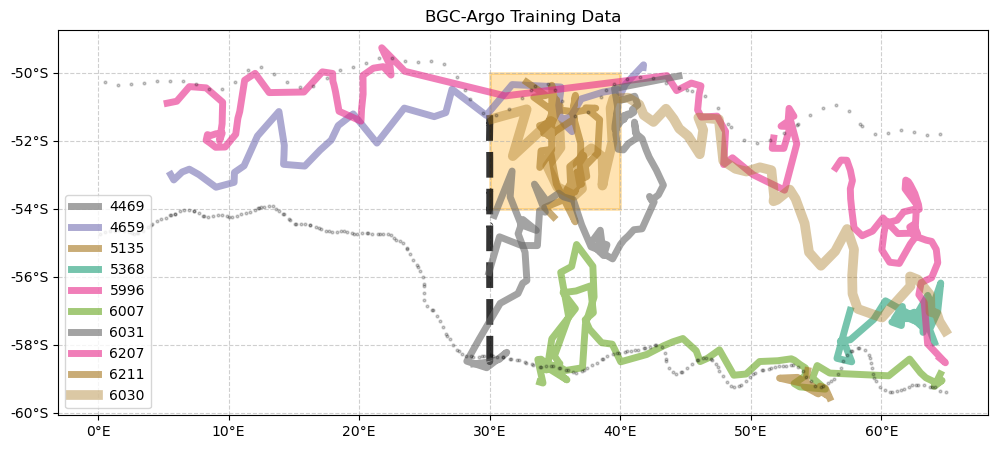

In [191]:
# Reference: Full matchup map for floats

fig = plt.figure(figsize=(12,5))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.6, linewidth=5, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)
    
lines = ax.get_lines()
# labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lines, align=False, fontsize=18, zorder=3)
ax.legend()

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)




plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

# labelLines(lins) # , align=False, fontsize=18)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)



/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 0 in `xvals` is outside the range of its associated line (xmin=28.246, xmax=33.568, xval=27.35). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 5 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=50.3). Clipping it into the allowed range.
  warnings.warn(


<AxesSubplot: >

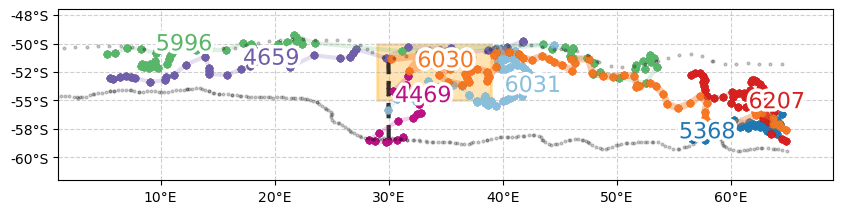

In [150]:
sgplot.training_float_map(floatDF, shipDF, ax=None, fsize = (10,8), fontsize=16)

### Optional variable: Add dN/dz


In [21]:
def add_nitrate_grad(platDF):
    """
    Calculate nitrate gradient dNO3/dZ using derivative of Pchip interpolator 
    @param      platDF: dataframe with argo profiles 
    @return     list of dataframes, each dataframe is a profile with a dN/dZ column added    
    """
    new_DF = pd.DataFrame()

    # profids = pd.unique(platDF.profid) # list of profile ids
    # profile_DFs = []
    # for i in range(len(profids)):
    #     profile_DFs.append(platDF[platDF['profid'] == profids[i]].copy())

    profile_DFs = dfproc.list_profile_DFs(platDF)

    for profile in profile_DFs:

        if np.isnan(profile.nitrate).all():
            nans = np.empty(len(profile['pressure'])); nans[:] = np.NaN
            profile.loc[:, 'grad_nitrate'] = nans
        else:
            f = scipy.interpolate.PchipInterpolator(x=profile.pressure.values, y=profile.nitrate.values, extrapolate = False)
            devf = f.derivative()
            grad_nitrate = devf(profile["pressure"].values)
            # 
            
            profile.loc[:, 'grad_nitrate'] = grad_nitrate
        
        # Take vert N2 and find the maximum in the profile. 
        
        new_DF = pd.concat([new_DF, profile])

    return new_DF

In [22]:
argo_dn = add_nitrate_grad(argo_qc)
argo_dn

wmoid      profid     yearday     lat     lon    pressure  \
N_PROF N_LEVELS                                                                
120    23        5904469  5904469120 -243.341968 -59.318  20.762   36.500000   
       80        5904469  5904469120 -243.341968 -59.318  20.762  122.030006   
       86        5904469  5904469120 -243.341968 -59.318  20.762  131.809998   
       134       5904469  5904469120 -243.341968 -59.318  20.762  211.309998   
       140       5904469  5904469120 -243.341968 -59.318  20.762  220.519989   
...                  ...         ...         ...     ...     ...         ...   
15     350       5906036  5906036015  315.945683 -40.387  43.905  699.739990   
       376       5906036  5906036015  315.945683 -40.387  43.905  751.739990   
       400       5906036  5906036015  315.945683 -40.387  43.905  799.739990   
       425       5906036  5906036015  315.945683 -40.387  43.905  849.739990   
       436       5906036  5906036015  315.945683 -40.387  43.905  871.739990   

                       CT         SA      oxygen    nitrate  ...  juld_qc  \
N_PROF N_LEVELS                                              ...            
120    23        0.571653  33.986129  331.772491  26.517487  ...        1   
       80        0.093973  34.462847  259.920380  32.085560  ...        1   
       86        0.417962  34.535569  237.983017  32.666294  ...        1   
       134       1.585580  34.799827  176.802002  33.558384  ...        1   
       140       1.620556  34.807129  176.287628  33.456509  ...        1   
...                   ...        ...         ...        ...  ...      ...   
15     350       6.923342  34.642290  200.832138  25.302105  ...        1   
       376       6.423527  34.596253  205.015198  26.430208  ...        1   
       400       5.984766  34.571306  205.229340  27.519115  ...        1   
       425       5.589732  34.553402  202.114029  28.282497  ...        1   
       436       5.517976  34.565541  201.930130  28.571844  ...        1   

                 position_qc  pressure_qc  temperature_qc  salinity_qc  \
N_PROF N_LEVELS                                                          
120    23                  1            1               8            8   
       80                  1            1               8            8   
       86                  1            1               8            8   
       134                 1            1               8            8   
       140                 1            1               8            8   
...                      ...          ...             ...          ...   
15     350                 1            1               1            2   
       376                 1            1               1            2   
       400                 1            1               1            2   
       425                 1            1               1            2   
       436                 1            1               1            2   

                oxygen_qc nitrate_qc pH_qc  buoyancy grad_nitrate  
N_PROF N_LEVELS                                                    
120    23               1          1     4  0.000040     0.070235  
       80               1          1     4  0.000040     0.061362  
       86               1          1     4  0.000037     0.022951  
       134              1          1     4  0.000003     0.000000  
       140              1          1     4  0.000003    -0.010035  
...                   ...        ...   ...       ...          ...  
15     350              1          1     1  0.000011     0.028100  
       376              1          1     1  0.000008     0.022185  
       400              1          1     1  0.000009     0.018276  
       425              1          1     1  0.000008     0.013996  
       436              1          1     1  0.000008     0.012506  

[31002 rows x 25 columns]

Text(0.5, 1.0, 'Nitrate Gradient: profid 5904659100')

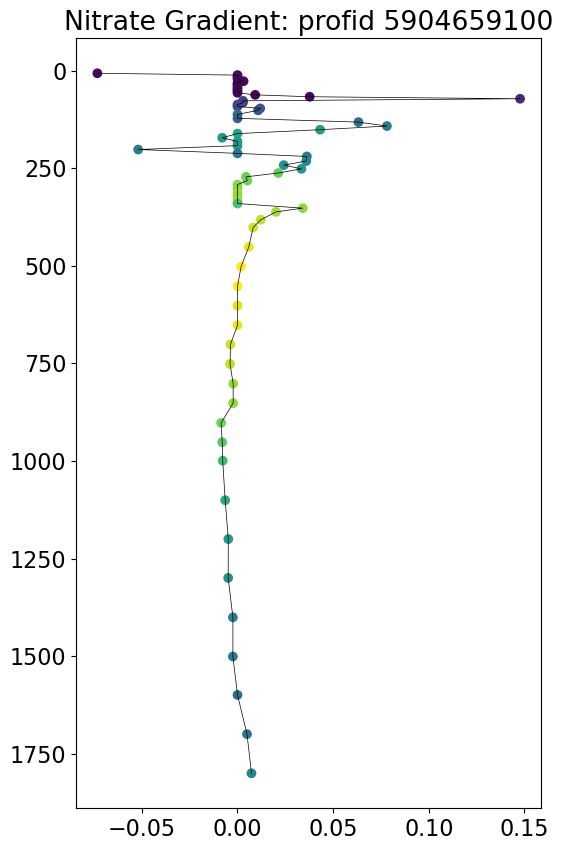

In [55]:
fig = plt.figure(figsize=(6, 10))
ax = fig.gca()

profile_DFs = list_profile_DFs(argo_dn)

prof = profile_DFs[20]

plt.scatter(prof.grad_nitrate, prof.pressure, c=prof.nitrate, cmap='viridis')
plt.plot(prof.grad_nitrate, prof.pressure, c='k', linewidth=0.5)
ax.invert_yaxis()
ax.set_title('Nitrate Gradient: profid ' + list(prof.profid)[1])

### Optional variable (outdated): Add distance to max buoyancy depth

In [20]:
## Add distance to maximum buoyancy depth
argo_dist2maxb = dfproc.add_dist2maxb(argo_dn)

AttributeError: 'DataFrame' object has no attribute 'buoyancy'

# 2.0 Add calculated variables

- Oxygen percent saturation / AOU
- Density gradient drho/dz
- Distance from the depth of maximum buoyancy frequency

# YES, do this for jun 24


In [159]:
# Add buoyancy to each profile
argo_qc = dfproc.add_Pchip_buoyancy(argo_qc)   


In [160]:
argo_qc

wmoid      profid     yearday     lat     lon    pressure  \
N_PROF N_LEVELS                                                                
85     3         5904469  5904469085 -603.853947 -54.200  30.351    7.530000   
       6         5904469  5904469085 -603.853947 -54.200  30.351   12.500000   
       10        5904469  5904469085 -603.853947 -54.200  30.351   17.540001   
       13        5904469  5904469085 -603.853947 -54.200  30.351   22.119999   
       17        5904469  5904469085 -603.853947 -54.200  30.351   27.539999   
...                  ...         ...         ...     ...     ...         ...   
38     428       5906211  5906211038  774.114421 -59.566  56.032  751.940002   
       454       5906211  5906211038  774.114421 -59.566  56.032  802.260010   
       480       5906211  5906211038  774.114421 -59.566  56.032  851.700012   
       506       5906211  5906211038  774.114421 -59.566  56.032  901.880005   
       531       5906211  5906211038  774.114421 -59.566  56.032  949.119995   

                       CT         SA      oxygen    nitrate  ...     sigma0  \
N_PROF N_LEVELS                                              ...              
85     3         1.854526  34.127837  326.251617  27.391092  ...  27.156790   
       6         1.854282  34.127824  326.255981  27.238417  ...  27.156799   
       10        1.855033  34.127808  326.220367  27.304010  ...  27.156729   
       13        1.854044  34.127803  326.004852  27.261232  ...  27.156800   
       17        1.853874  34.127820  325.960205  27.058727  ...  27.156826   
...                   ...        ...         ...        ...  ...        ...   
38     428       1.677812  34.893777  189.417236  31.769651  ...  27.780708   
       454       1.632283  34.896845  191.198868  31.593346  ...  27.786584   
       480       1.574263  34.896935  192.379654  31.547487  ...  27.790987   
       506       1.538334  34.899017  194.018814  31.288752  ...  27.795310   
       531       1.488704  34.900096  195.298828  31.324482  ...  27.799820   

                    spice  juld_qc  position_qc pressure_qc temperature_qc  \
N_PROF N_LEVELS                                                              
85     3        -0.588261        1            1           1              8   
       6        -0.588291        1            1           1              8   
       10       -0.588239        1            1           1              8   
       13       -0.588326        1            1           1              8   
       17       -0.588329        1            1           1              8   
...                   ...      ...          ...         ...            ...   
38     428      -0.066190        1            1           1              8   
       454      -0.067885        1            1           1              8   
       480      -0.072680        1            1           1              8   
       506      -0.074207        1            1           1              8   
       531      -0.077546        1            1           1              8   

                salinity_qc oxygen_qc nitrate_qc      buoyancy  
N_PROF N_LEVELS                                                 
85     3                  8         1          1 -1.053799e-07  
       6                  8         1          1 -1.053799e-07  
       10                 8         1          1  1.842531e-08  
       13                 8         1          1  1.184602e-07  
       17                 8         1          1 -4.547756e-08  
...                     ...       ...        ...           ...  
38     428                8         1          1  1.445205e-06  
       454                8         1          1  1.213222e-06  
       480                8         1          1  1.044388e-06  
       506                8         1          1  1.053890e-06  
       531                8         1          1  1.053890e-06  

[26202 rows x 22 columns]

In [161]:
# Add oxygen metrics, oxygen saturation, 
argo_qc['AOU'] = gsw.O2sol(argo_qc['SA'], argo_qc['CT'], argo_qc['pressure'], argo_qc['lon'], argo_qc['lat']) - argo_qc['oxygen']
argo_qc['o2sat'] = gsw.O2sol(argo_qc['SA'], argo_qc['CT'], argo_qc['pressure'], argo_qc['lon'], argo_qc['lat'])

# argo_qc['oxygen_psat'] = argo_qc['oxygen']/argo_qc['o2sat']

In [162]:
# Set up lists of WMOs
wmo_list = pd.unique(argo_data['wmoid'])  # 13 total in spatial/temporal range
wmoids = pd.unique(argo_qc['wmoid'])  # 12 with good nitrate
# qcdrop = [x for x in wmo_list if x not in wmo_qc]

# floats that did not pass QC
# print(qcdrop) 
print(); print('WMO    ' + '\t # obs')
print(argo_qc.wmoid.value_counts())


WMO    	 # obs
5905996    3837
5906007    3725
5906030    3644
5906031    3552
5906207    2777
5904659    2698
5905135    2652
5905368    1622
5904469    1103
5906211     592
Name: wmoid, dtype: int64


In [163]:
# Remove any floats that have fewer than 200 obs
newdf = pd.DataFrame()
for wmo in wmoids: 
    flo = argo_qc[argo_qc.wmoid==wmo]
    if len(flo)>200:
        newdf = pd.concat([newdf, flo])
argo_qc = newdf.copy()

In [194]:
wmoids

array([5904469, 5904659, 5905135, 5905368, 5905996, 5906007, 5906030,
       5906031, 5906207, 5906211])

In [195]:
valid_wmoids = [5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207]
argo_temp = argo_qc[argo_qc.wmoid.isin(valid_wmoids)]

In [196]:
argo_temp.wmoid.unique()

array([5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207])

In [179]:
print_bounds(argo_temp)

Dates: 		2017-05-08 to 2021-07-11
Latitude:	-58.682 to -49.263
Longitude:	5.3 to 64.896


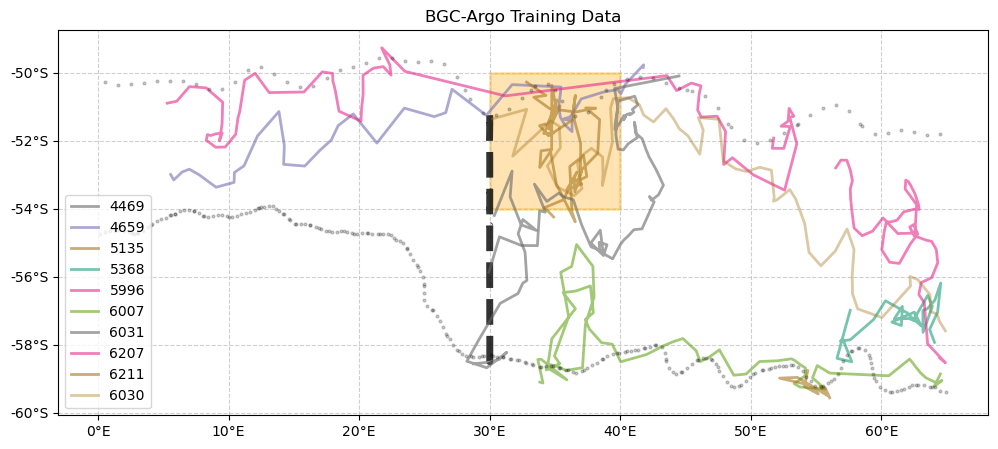

In [192]:
# Reference: Full matchup map for floats

fig = plt.figure(figsize=(12,5))
ax=plt.gca()

for wmo in wmoids[wmoids!=5906030]:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.6, linewidth=2, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=2, label=str(wmo)[3:], zorder=3)
#     ax.scatter(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
#             color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)
    
lines = ax.get_lines()
# labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lines, align=False, fontsize=18, zorder=3)
ax.legend()

for front in [SIF, PF]:
     front = front[(front.lon > 0 ) & (front.lon <65)]
     ax.scatter(front.lon, front.lat, color='k', alpha=0.2, s=4, zorder=3)
#      ax.plot(front.lon, front.lat, color='k', alpha=0.1, linewidth=2, zorder=3)




plt.title('BGC-Argo Training Data')
# plt.title('Argo Yeardays: ' + str(start_yd) + ' to ' + str(end_yd))
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.3,linewidth=2, zorder=1)

# ax.legend()
ax.add_patch(rect)
# ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

# labelLines(lins) # , align=False, fontsize=18)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)



/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 8 in `xvals` is outside the range of its associated line (xmin=56.495, xmax=64.896, xval=20.681818181818183). Clipping it into the allowed range.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/mlsogos/lib/python3.8/site-packages/labellines/core.py:204: UserWarning: The value at position 9 in `xvals` is outside the range of its associated line (xmin=52.197, xmax=56.032, xval=26.40909090909091). Clipping it into the allowed range.
  warnings.warn(


[Text(32.13636363636364, -54.21075728886498, '4469'),
 Text(14.954545454545455, -52.717381661442005, '4659'),
 Text(37.86363636363637, -51.060025974025976, '5135'),
 Text(60.77272727272727, -56.81172326362553, '5368'),
 Text(9.227272727272727, -50.7599191440471, '5996'),
 Text(55.04545454545455, -59.289858380030566, '6007'),
 Text(49.31818181818182, -52.873502437967275, '6030'),
 Text(43.59090909090909, -50.16124048347275, '6031'),
 Text(64.0559, -55.10580084507042, '6207'),
 Text(55.6485, -59.4497403516295, '6211')]

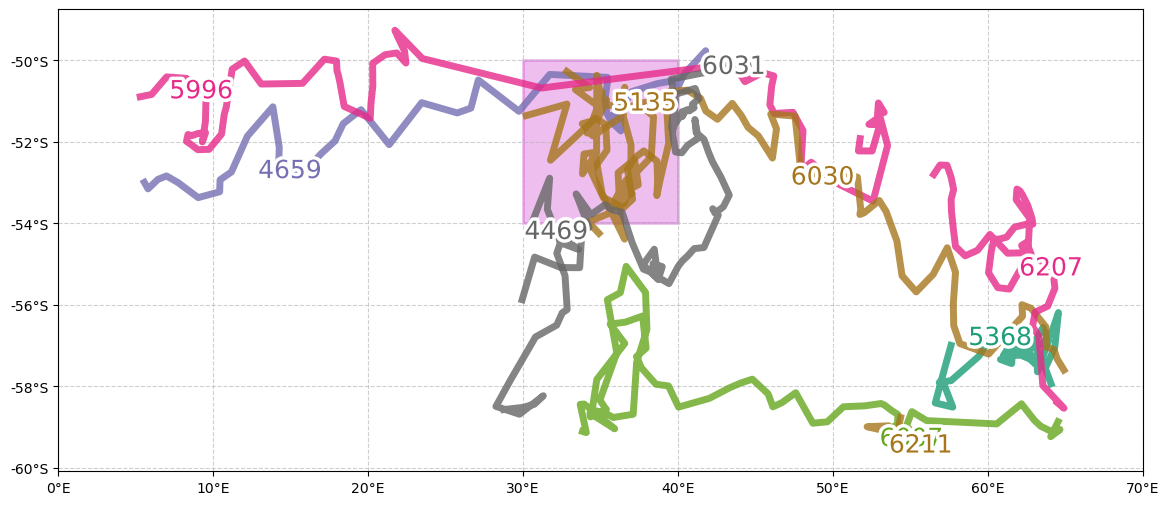

In [193]:
# Reference: Full matchup map for floats, so we can see where the  floats are
fig = plt.figure(figsize=(14,6))
ax=plt.gca()

for wmo in pd.unique(argo_qc.wmoid):
    ax.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.8, linewidth=5, label=str(wmo)[3:], zorder=3)
    
# plt.title('SOGOS BGC-Argo Matchups, no temp drop (2017-2021)')
rect = patch.Rectangle((30,-54),10,4, fill=True, color="m", alpha=0.25,linewidth=2, zorder=1)

ax.add_patch(rect)
ax.set_xlim(0,70)

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)


In [ ]:
valid_wmoids = [5904469, 5904659, 5905368, 5905996, 5906030, 5906031, 5906207]
argo_temp = argo_qc[argo_qc.wmoid.isin(valid_wmoids)]

# 2.0 Figures: Float Dataset Exploration

## 2.1 Plot Float Maps

In [46]:
# Set up color palettes for plotting
size = 22
params = {'legend.fontsize': size-4, 
          'xtick.labelsize':size, 
          'ytick.labelsize':size, 
          'font.size':size,
          'font.family':'Futura'}
plt.rcParams.update(params)

# Set up WMO colors
pal = sns.color_palette("Paired", 30)
wmo_colors = dict.fromkeys(wmoids)
for i, wmo in enumerate(wmoids):
    wmo_colors[wmo] = pal[i]
wmo_colors[5906030]=sns.color_palette("Reds")[5]


varmin = -1.951301e-06
varmax = 1.130347e-04

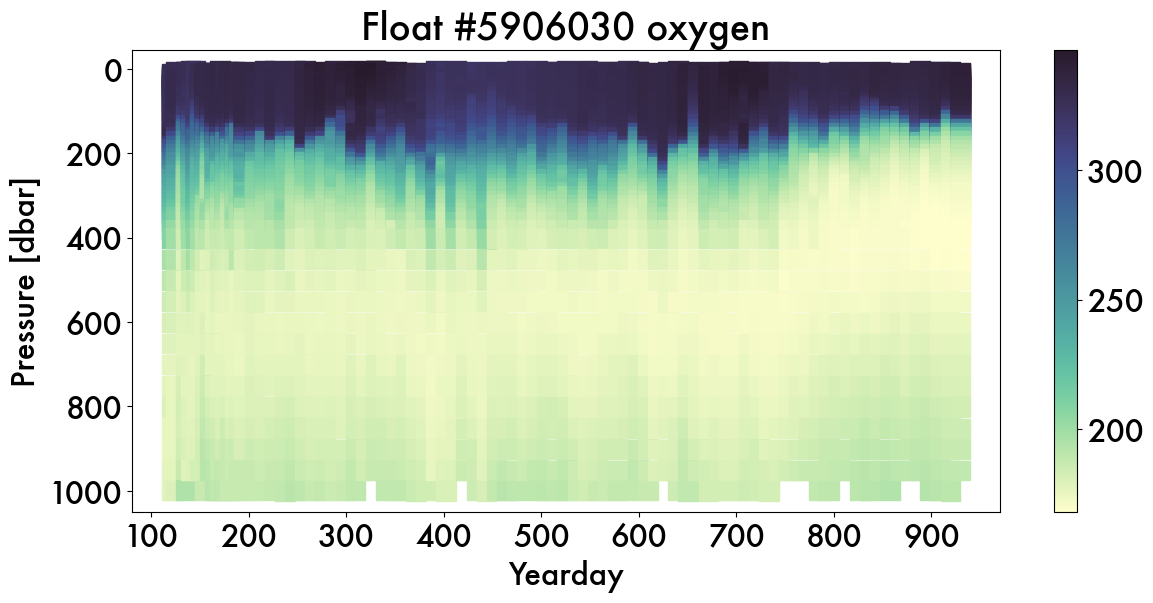

In [41]:
# PLOT: single float variable profiles

wmo = 5906030
dat = argo_qc[argo_qc.wmoid==wmo]
var = 'oxygen'

fig = plt.figure(figsize=(14,6))
plt.scatter(dat.yearday, dat.pressure, c=dat[var], cmap=cmo.deep, s=200, marker='s') #, vmin=varmin, vmax=varmax)
ax=plt.gca()
ax.invert_yaxis()

ax.set_title('Float #' + str(wmo) + ' ' + var)
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
plt.colorbar()


# fig = plt.figure(figsize=(12,5))
# plt.scatter(dat.yearday[180:340], dat.pressure[180:340], c=dat.oxygen[180:340], cmap=cmo.amp, s=200, marker='s')
# ax=plt.gca()
# ax.invert_yaxis()
# ax.set_title('BGC-Argo Float #5906030')
# ax.set_ylabel('Pressure [dbar]')
# ax.set_xlabel('Yearday')




IndexError: index 12 is out of bounds for axis 0 with size 12

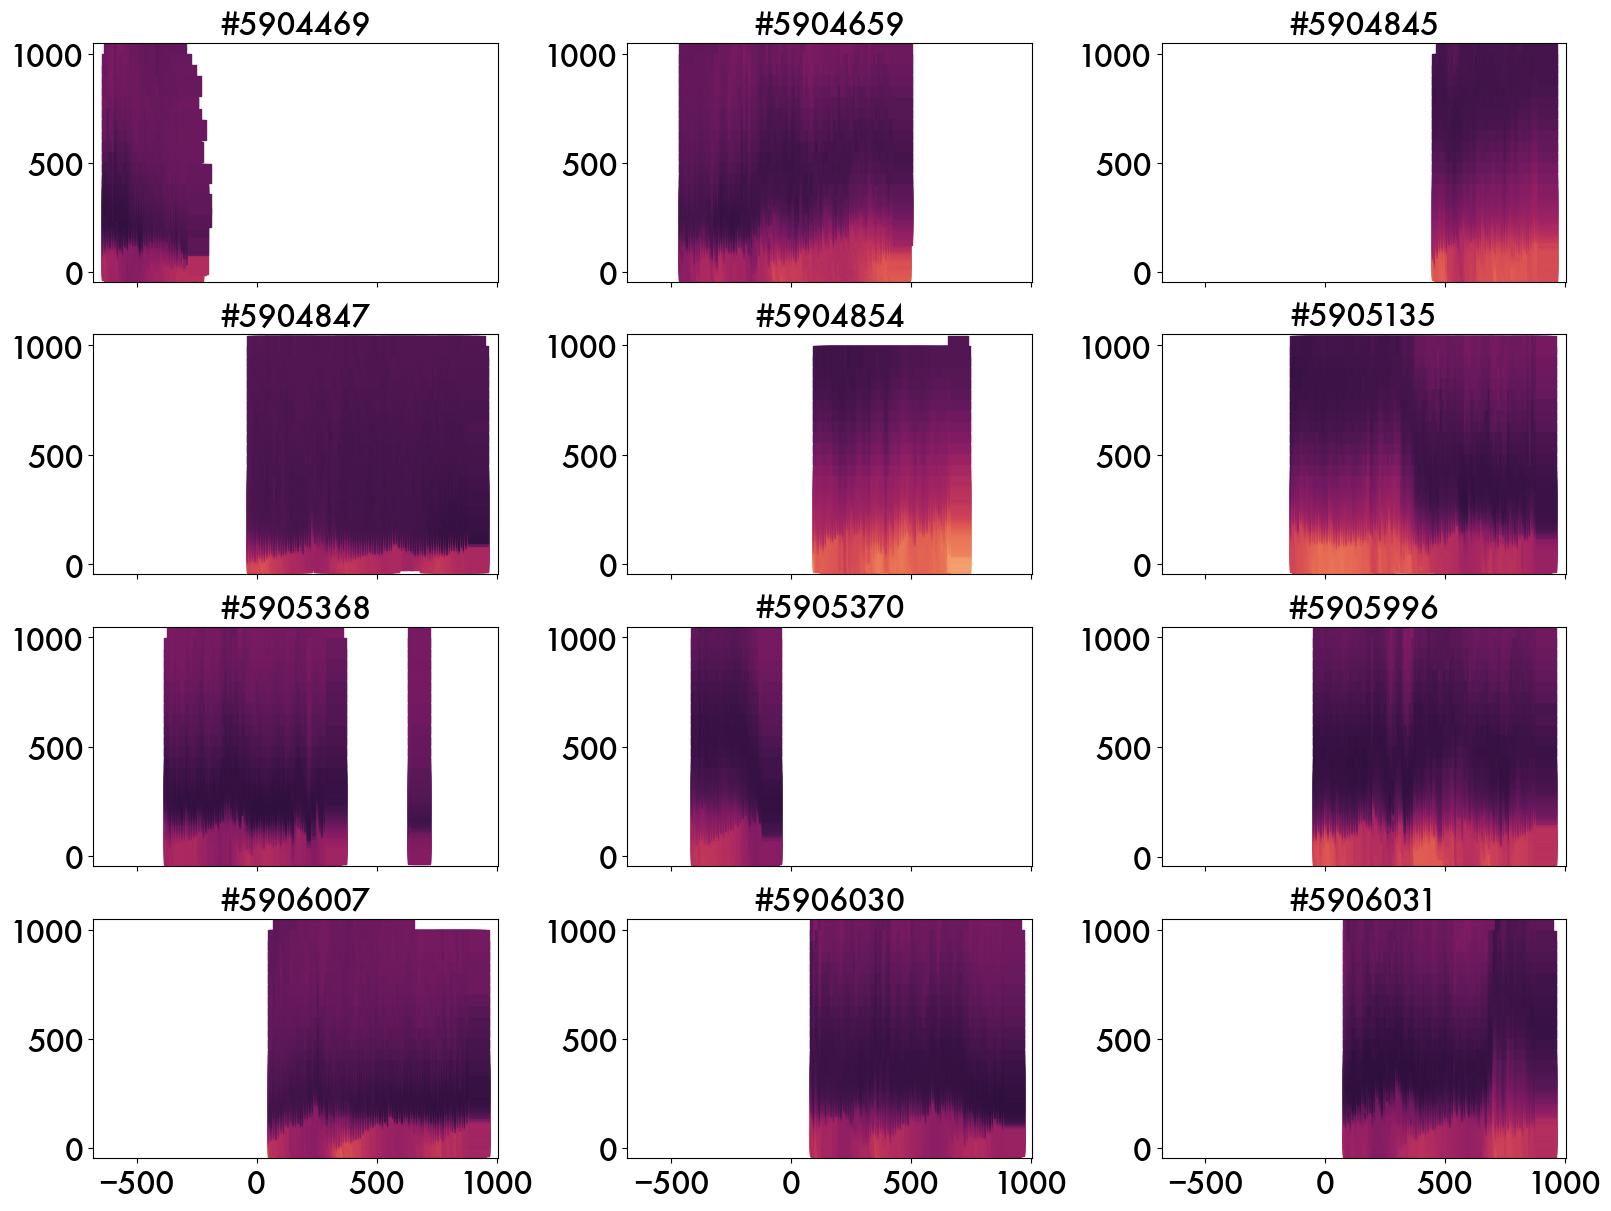

In [42]:
fig, axes = plt.subplots(4,3, figsize=(16,12), sharex=True, constrained_layout=True)
axs = axes.flatten()

for ind, wmo in enumerate(wmoids):
    dat = argo_qc[argo_qc.wmoid==wmo]

    sca = axs[ind].scatter(dat.yearday, dat.pressure, c=dat.nitrate, cmap=cmo.matter, s=200, vmin=12, vmax=36, marker='s')
    axs[ind].set_title('#' + str(wmo), fontsize=22)

for ax in axs:
    ax.invert_yaxis()

fig.colorbar(sca, ax=axes[:,2], shrink=0.5).set_label('Nitrate (umol/kg)')
# plt.colorbar()
# axs[2].invert_yaxis()
# ax.set_ylabel('Pressure [dbar]')
# axs[-1].set_xlabel('Yearday')

# axes[0,:].set_title('Nitrate profiles across floats')


# 3.0 Float Selection

- Explore why float distributions do not match with glider distributions
- Notice higher temp and salinity

## Consider time coverage and temperature.

Text(0.5, 0, 'Yearday (0 = Jan 1 2019)')

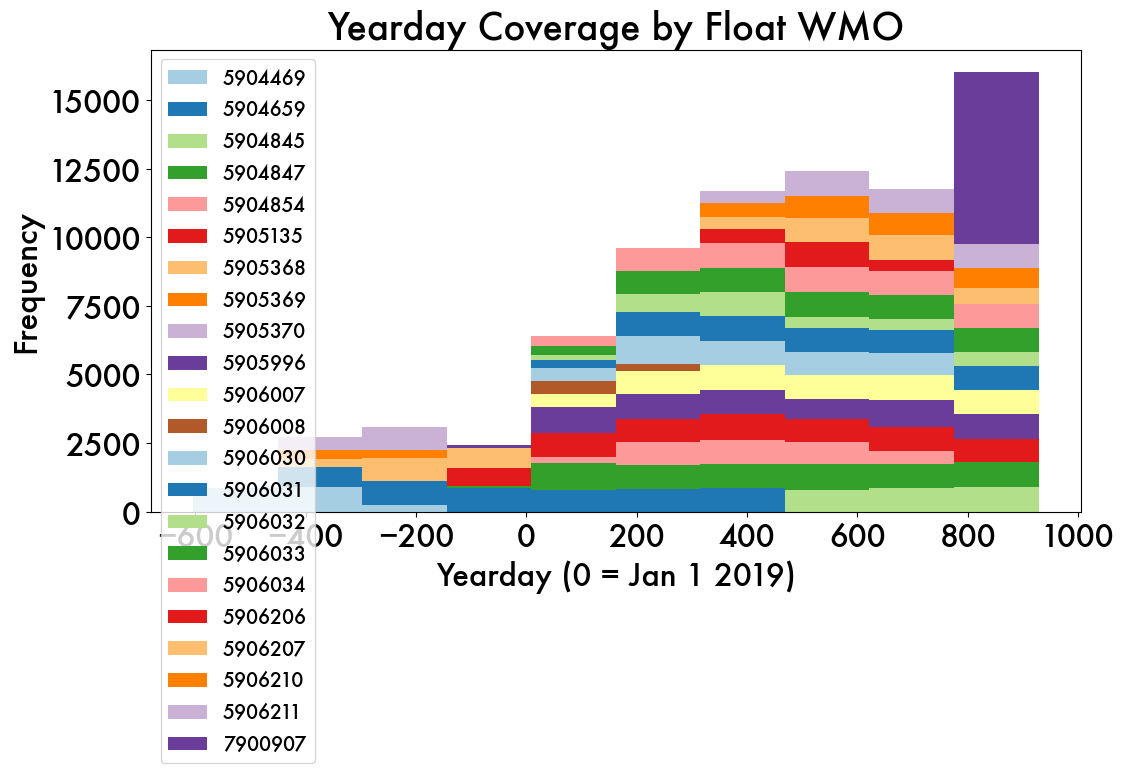

In [64]:
# argo_qc.pivot(columns='wmoid').yearday.plot(kind = 'hist', stacked=True)
pal = sns.color_palette("Paired")
sns.set_palette(pal)

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
pd.DataFrame({k: v for k, v in argo_qc.groupby('wmoid').yearday}).plot.hist(stacked=True, ax=ax) 
ax.legend(loc='upper left', fontsize=14)
ax.set_title('Yearday Coverage by Float WMO')
ax.set_xlabel('Yearday (0 = Jan 1 2019)')

- 7900907 removed for yearday (late time coverage)

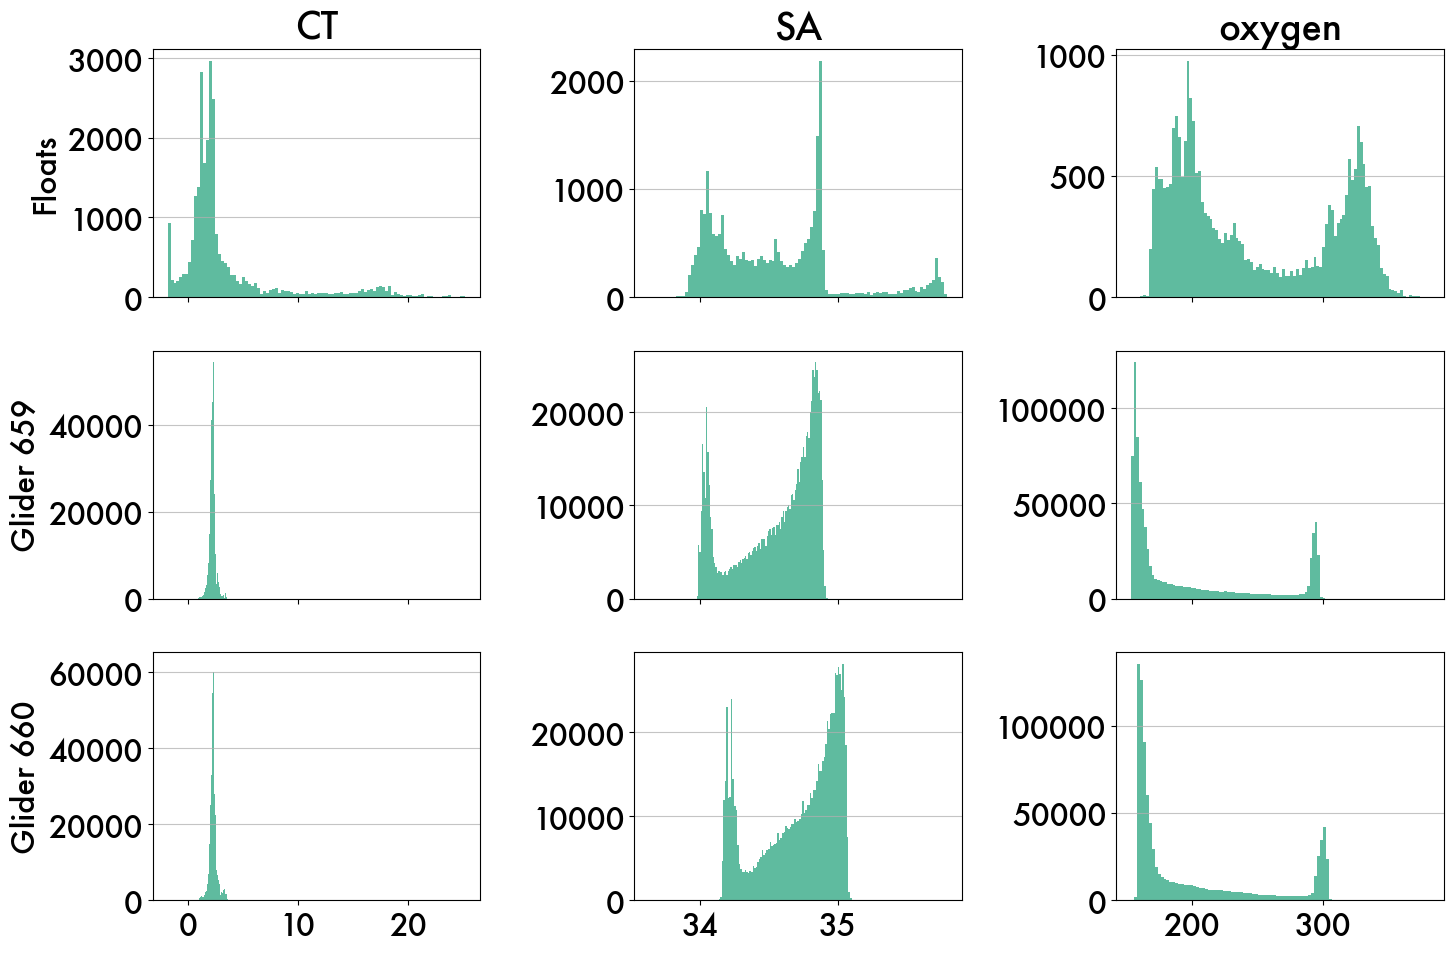

In [65]:
# Variable distributions from training ship/float data before dropping floats
nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['CT', 'SA', 'oxygen']):
    axs[0,c].hist(x=argo_qc[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Floats')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)

## Explore out-of range ("bad") temperatures

In [65]:
# Determine which wmo floats have high temperatures
hightemp = argo_qc[argo_qc.CT>5]
hightemp.describe()
hightemp.wmoid.value_counts()

# hightemp.yearday.describe()

5904854    1651
5906032    1367
5905135     614
5904845     481
5906206     229
5905996     154
5904659     139
5906031      79
Name: wmoid, dtype: int64

[Text(44.0, -49.142371495327104, '4659'),
 Text(28.0, -47.51544444444444, '4845'),
 Text(12.0, -47.838137719969396, '4854'),
 Text(20.0, -47.273302917442585, '5135'),
 Text(52.0, -53.34560240963855, '5996'),
 Text(36.0, -53.69079005524862, '6031'),
 Text(68.0, -45.42083349900596, '6032'),
 Text(60.0, -48.667463687150835, '6206')]

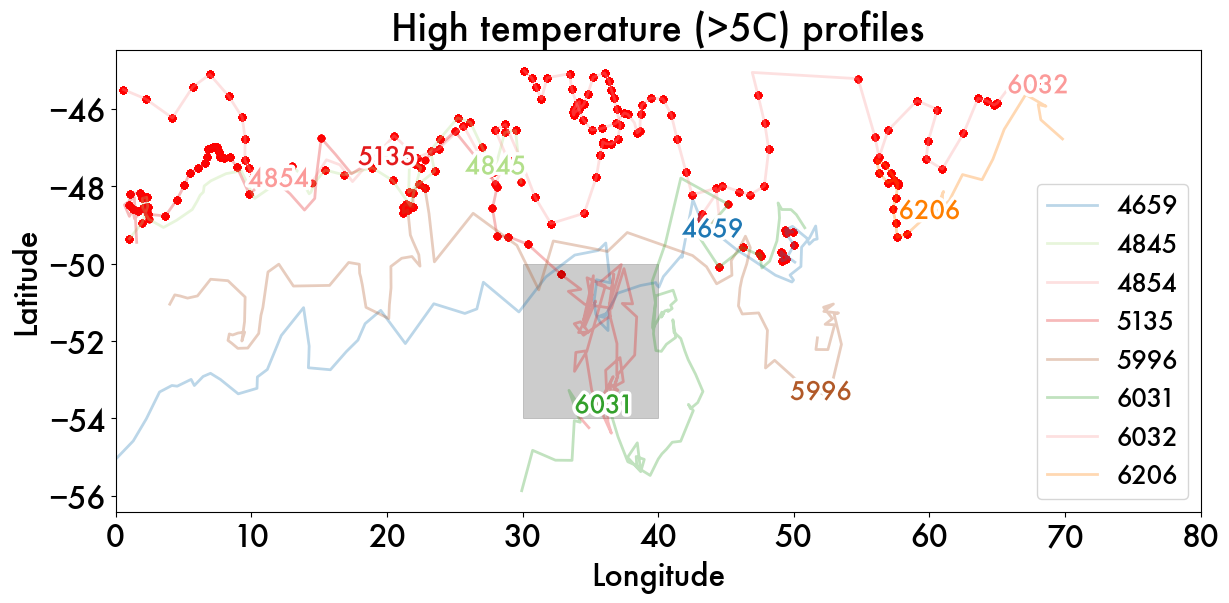

In [66]:
# PLOT: Show high temps as red points on surface lat/lon map
fig = plt.figure(figsize=(14,6))
pal = sns.color_palette("Paired")
sns.set_palette(pal)

# for wmo in pd.unique(argo_qc.wmoid):
for wmo in pd.unique(hightemp.wmoid):
    plt.plot(argo_qc[argo_qc.wmoid==wmo].lon,argo_qc[argo_qc.wmoid==wmo].lat, label=str(wmo)[3:], 
                        color=wmo_colors[wmo], linewidth=2, alpha=0.3)
for wmo in (pd.unique(hightemp.wmoid)):
    # plt.scatter(hightemp[hightemp.wmoid==wmo].lon,hightemp[hightemp.wmoid==wmo].lat, color=wmo_colors[wmo], s=20)
    plt.scatter(hightemp[hightemp.wmoid==wmo].lon,hightemp[hightemp.wmoid==wmo].lat, c='r', s=20)

plt.legend()
plt.title('High temperature (>5C) profiles')
rect = patch.Rectangle((30,-54),10,4,fill=True,color="k", alpha=0.2,linewidth=0.6)

ax=plt.gca()
ax.add_patch(rect)
ax.set_xlim(0,80)
ax.set_xlabel('Longitude')
# ax.set_ylim(-60,-30)
ax.set_ylabel('Latitude')

labelLines(ax.get_lines(), align=False, fontsize=18)

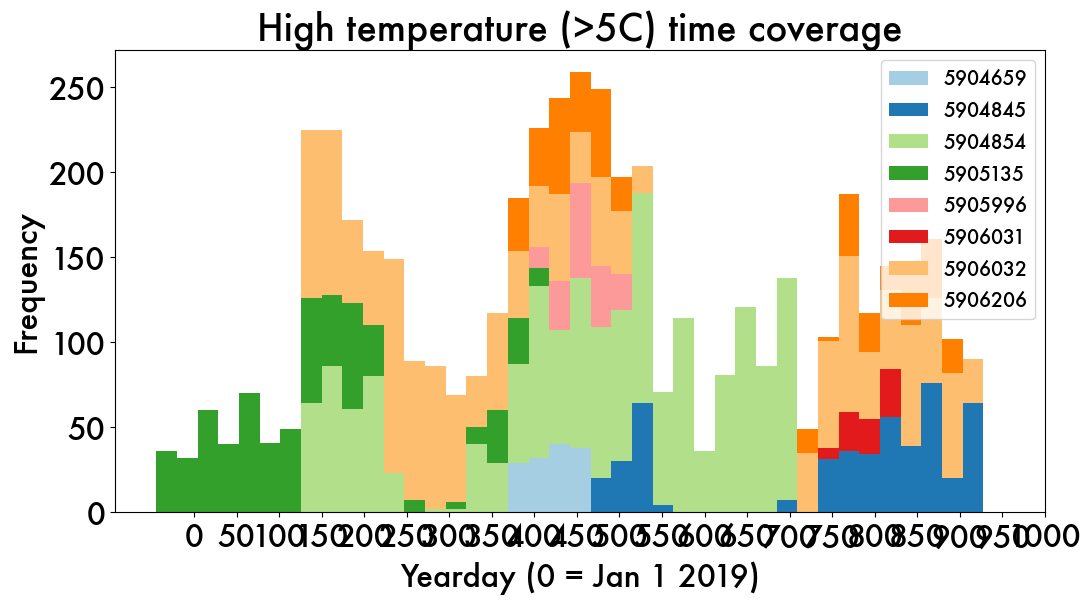

In [48]:
# PLOT: Show time coverage of bad temperature data
pal = sns.color_palette("Paired")
sns.set_palette(pal)

fig = plt.figure(figsize=(12,6))
ax = plt.gca()
pd.DataFrame({k: v for k, v in hightemp.groupby('wmoid').yearday}).plot.hist(stacked=True, ax=ax, bins=40) 
ax.legend(loc='upper right', fontsize=14)
ax.set_title('High temperature (>5C) time coverage')
ax.set_xlabel('Yearday (0 = Jan 1 2019)')
ax.set_xticks(np.arange(00,1001,50))


Text(0.5, 0, 'Yearday')

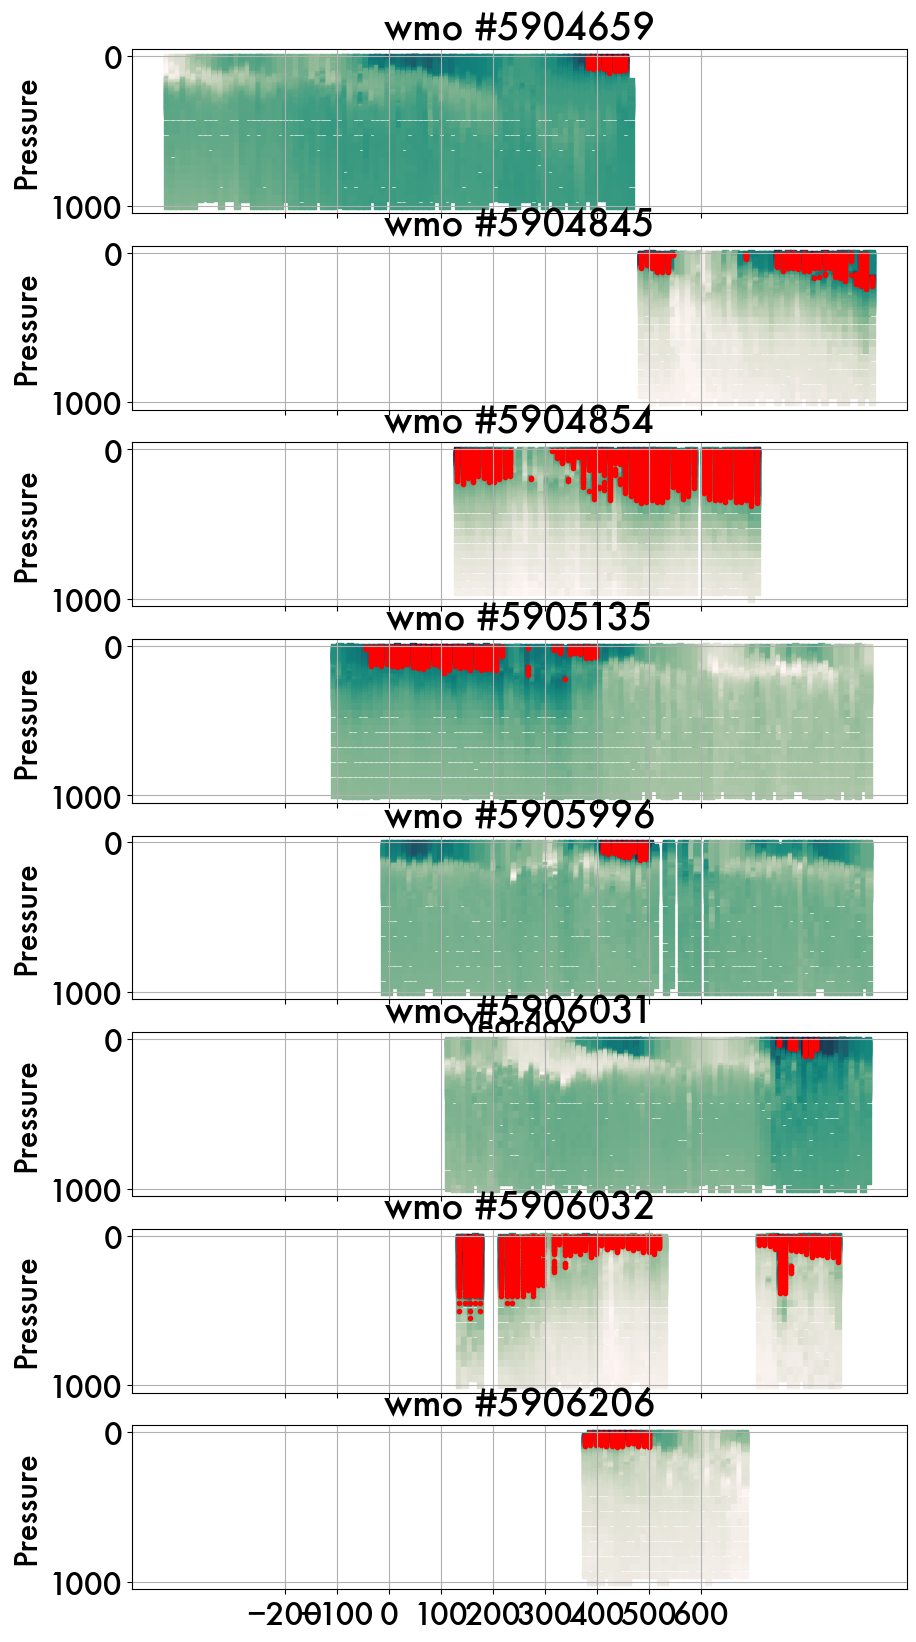

In [70]:
# PLOT: Show where bad temps are in profile
fig, axs = plt.subplots(8,1, sharex=True, figsize=(10,20))
axs = axs.flatten()

for i, wmo in enumerate(pd.unique(hightemp.wmoid)):
    tempf = argo_qc[argo_qc.wmoid==wmo].copy()
    axs[i].scatter(tempf.yearday, tempf.pressure, c=tempf.CT, cmap=cmo.tempo, s=20, marker='s')

    bad = hightemp[hightemp.wmoid==wmo]
    # axs[i].scatter(badyd, np.tile(0,len(badyd)), c='r', marker='.')
    axs[i].scatter(bad.yearday, bad.pressure, c='r', marker='.')
    axs[i].set_title('wmo #' + str(wmo))

for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Pressure')
    ax.set_xticks(np.arange(-200,601,100))
    ax.grid(zorder=3)

axs[4].set_xlabel('Yearday')


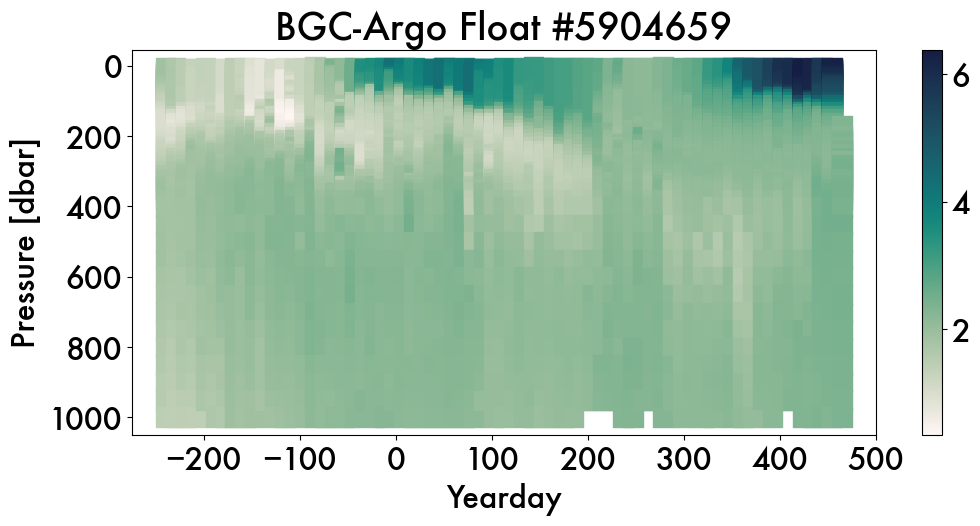

In [657]:
# singple float plot
# float_4659['nprof'] = float_4659.index.get_level_values('N_PROF') 
# float_4659.CT.plot()

fig = plt.figure(figsize=(12,5))
plt.scatter(float_4659.yearday, float_4659.pressure, c=float_4659.CT, cmap=cmo.tempo, s=200, marker='s')
ax=plt.gca()
ax.invert_yaxis()
ax.set_title('BGC-Argo Float #5904659')
ax.set_ylabel('Pressure [dbar]')
ax.set_xlabel('Yearday')
plt.colorbar()


- 5906032, 5904854, 5906206, 5904845, 5905135 removed for high temperatures / too high latitude

# 4.0 Remove floats and save

<!-- - 7900907, 7900915, 7900918 removed for yearday
- 5906034, 5906033, 5906210, 5906211 removed for too low latitude
- 5906032, 5904854, 5906206, 5904845, 5905135 removed for high temperatures / too high latitude
- 5904847 spatial blocking 

[7900907, 7900915, 7900918, 
                   5906034, 5906033, 5906210, 5906211,
                   5906032, 5904854, 5906206, 5904845, 5905135, 
                   5904847]  -->

sep 17
- 7900907 removed for yearday
- 5906032, 5905135, 5904854, 5904845 removed for high temperatures / too high latitude


NameError: name 'argo_final' is not defined

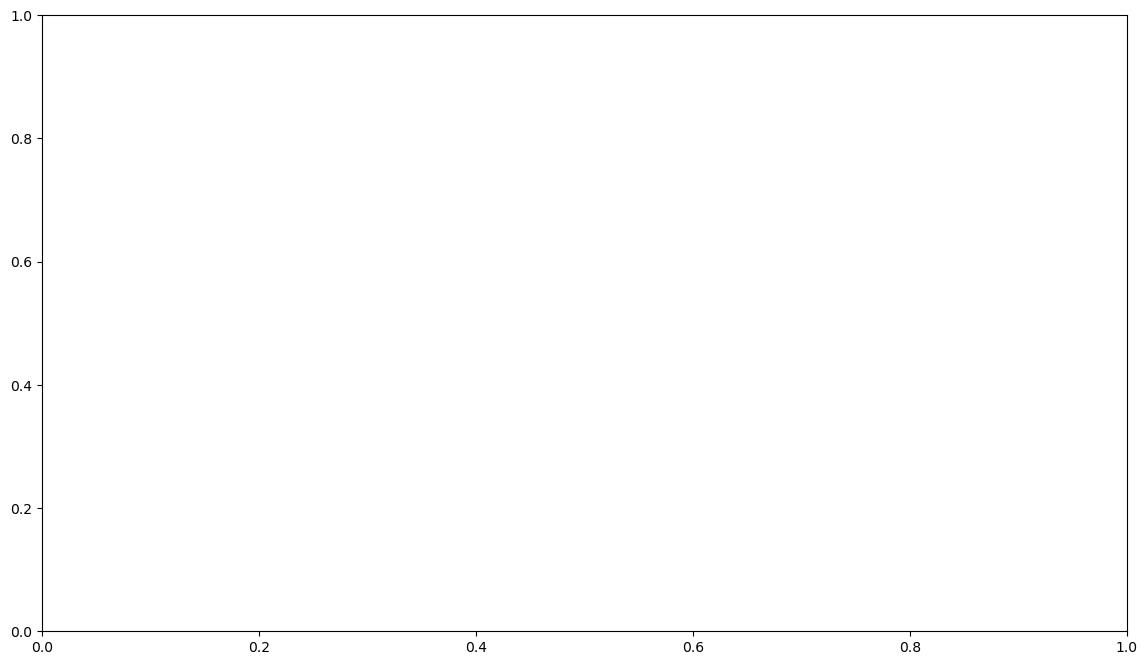

In [168]:
# Reference: Full matchup map for floats, so we can see where the holdout floats are
fig = plt.figure(figsize=(14,8))
ax=plt.gca()

for wmo in wmoids:
    if wmo!=5906030:
        ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
                color = wmo_colors[wmo], alpha=0.2, linewidth=5, label=str(wmo)[3:], zorder=3)
        ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
                color = wmo_colors[wmo], alpha=0.1, s=20, zorder=3)

for wmo in [5906030]:
    ax.plot(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.4, linewidth=7, label=str(wmo)[3:], zorder=3)
    ax.scatter(argo_final[argo_final.wmoid==wmo].lon,argo_final[argo_final.wmoid==wmo].lat,
            color = wmo_colors[wmo], alpha=0.1, s=30, zorder=3)

plt.title('SOGOS BGC-Argo Matchups (2017-2021)')
rect = patch.Rectangle((30,-54),10,4, fill=True, color="orange", alpha=0.25,linewidth=2, zorder=1)


# ax.legend()
ax.add_patch(rect)
ax.set_xlim(5,81)
# ax.set_ylim(-60,-30)
# ax.set_aspect('equal')

ax.yaxis.set_major_formatter("{x:1.0f}°S")
ax.xaxis.set_major_formatter("{x:1.0f}°E")

ax.grid(linestyle='dashed', alpha=0.6, zorder=1)

lines = ax.get_lines()
labelLines(lines, align=False, fontsize=18, zorder=3)
# labelLines(lins) # , align=False, fontsize=18)
# plt.plot(shipDF.lon, shipDF.lat, alpha=0.8, linestyle='dashed', c='k', linewidth=5)

# Plot Comparisons with Ship, Glider

NameError: name 'df_659' is not defined

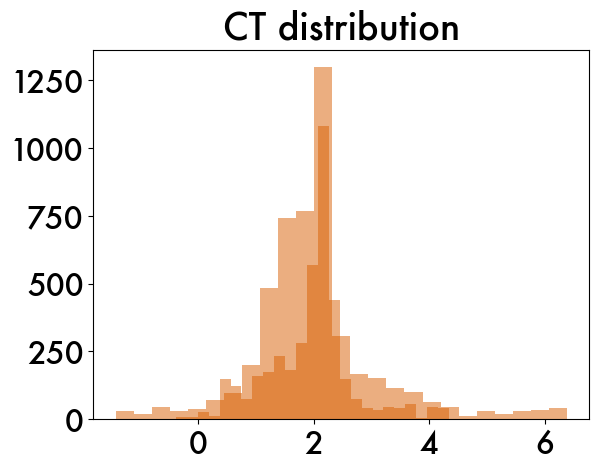

In [84]:
# Compare distributions of two floats and a glider
argofloat = argo_qc[argo_qc.wmoid==5906030]
plt.hist(argofloat.CT, bins=25, color=wmo_colors[5906030], alpha=0.5, label="5906030")
plt.title('CT distribution')

argofloat = argo_qc[argo_qc.wmoid==5904659]
plt.hist(argofloat.CT, bins=25, color=wmo_colors[5904659], alpha=0.5, label="5904659")

# bad_6032 = badtemp[badtemp.wmoid==5906032]
# bad_6032.describe()
# plt.hist(bad_6032.CT, bins=25, color=wmo_colors[5906032], alpha=0.5, label="5906032")


plt.hist(df_659.CT.iloc[200:70000:40], bins=25, color='k', alpha=0.8, label="glider (subset)")
plt.legend()

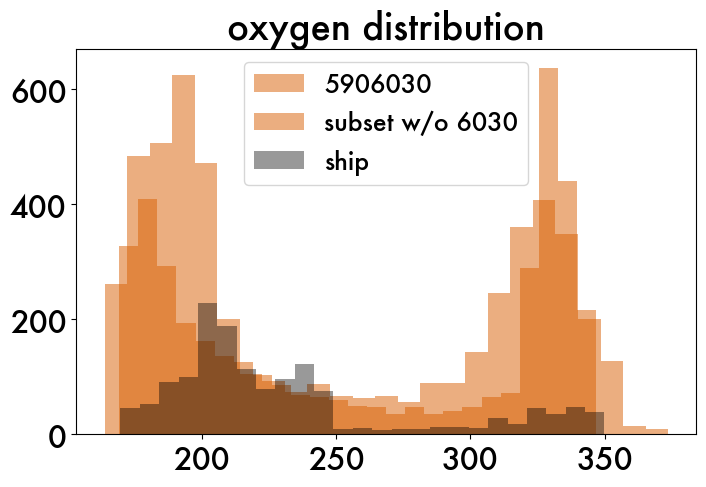

In [88]:
# compare float 6030 with rest of floats, and the ship
fig = plt.figure(figsize=(8,5))

argofloat = argo_final[argo_final.wmoid==5906030]
plt.hist(argofloat.oxygen, bins=25, color=wmo_colors[5906030], alpha=0.5, label="5906030")
plt.title('oxygen distribution')

argofloat = argo_final[argo_final.wmoid!=5906030][0::10]
plt.hist(argofloat.oxygen, bins=25, color=wmo_colors[5904659], alpha=0.5, label="subset w/o 6030")

plt.hist(shipDF.oxygen, bins=25, color='k', alpha=0.4, label="ship")
# plt.hist(df_659.oxygen[200:70000:40], bins=25, color='k', alpha=0.8, label="glider (subset)")

plt.legend()

In [89]:
# compare 6032 with others
fig = plt.figure(figsize=(8,5))
argofloat = argo_qc[argo_qc.wmoid==5906032]
plt.hist(argofloat.nitrate, bins=25, color=wmo_colors[5906032], alpha=0.5, label="5906032")
plt.title('nitrate distribution')

argofloat = argo_qc[argo_qc.wmoid!=5906032][0::10]
plt.hist(argofloat.nitrate, bins=25, color=wmo_colors[5904659], alpha=0.7, label="subset w/o 6032")

plt.hist(shipDF.nitrate, bins=25, color='k', alpha=0.4, label="ship")

# plt.hist(df_659.nitrate[200:70000:40], bins=25, color='k', alpha=0.9, label="glider (subset)")

plt.legend()

KeyError: 5906032

<Figure size 800x500 with 0 Axes>

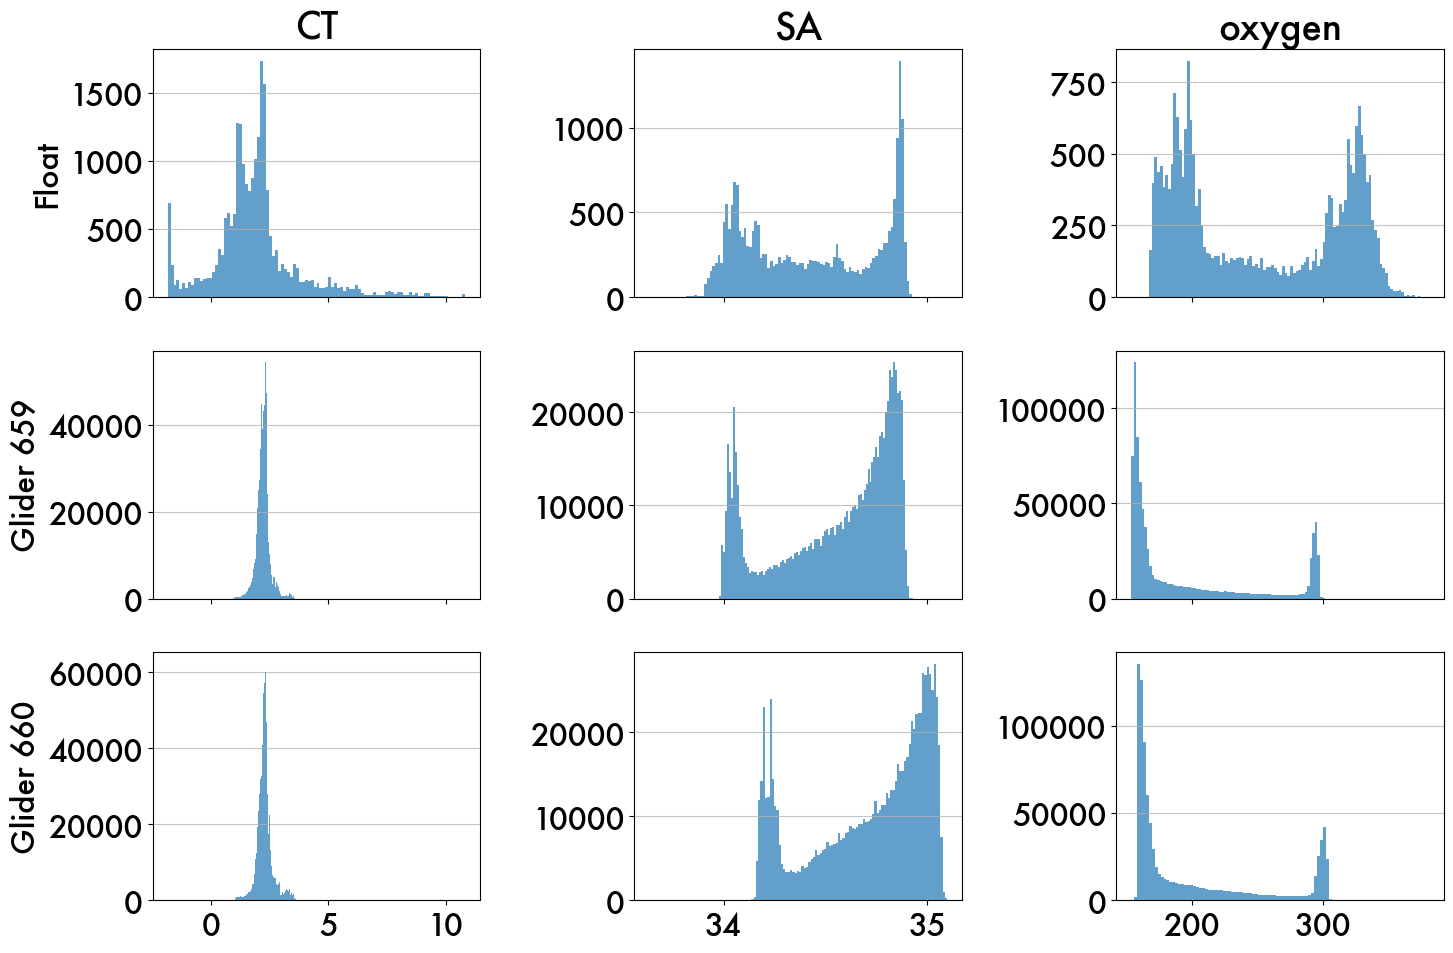

In [24]:
# Variable distributions from training ship/float data before dropping floats
nbins = 100
fig, axs = plt.subplots(3, 3, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['CT', 'SA', 'oxygen']):
    axs[0,c].hist(x=argo_final[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Float')
axs[1,0].set_ylabel('Glider 659')
axs[2,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)


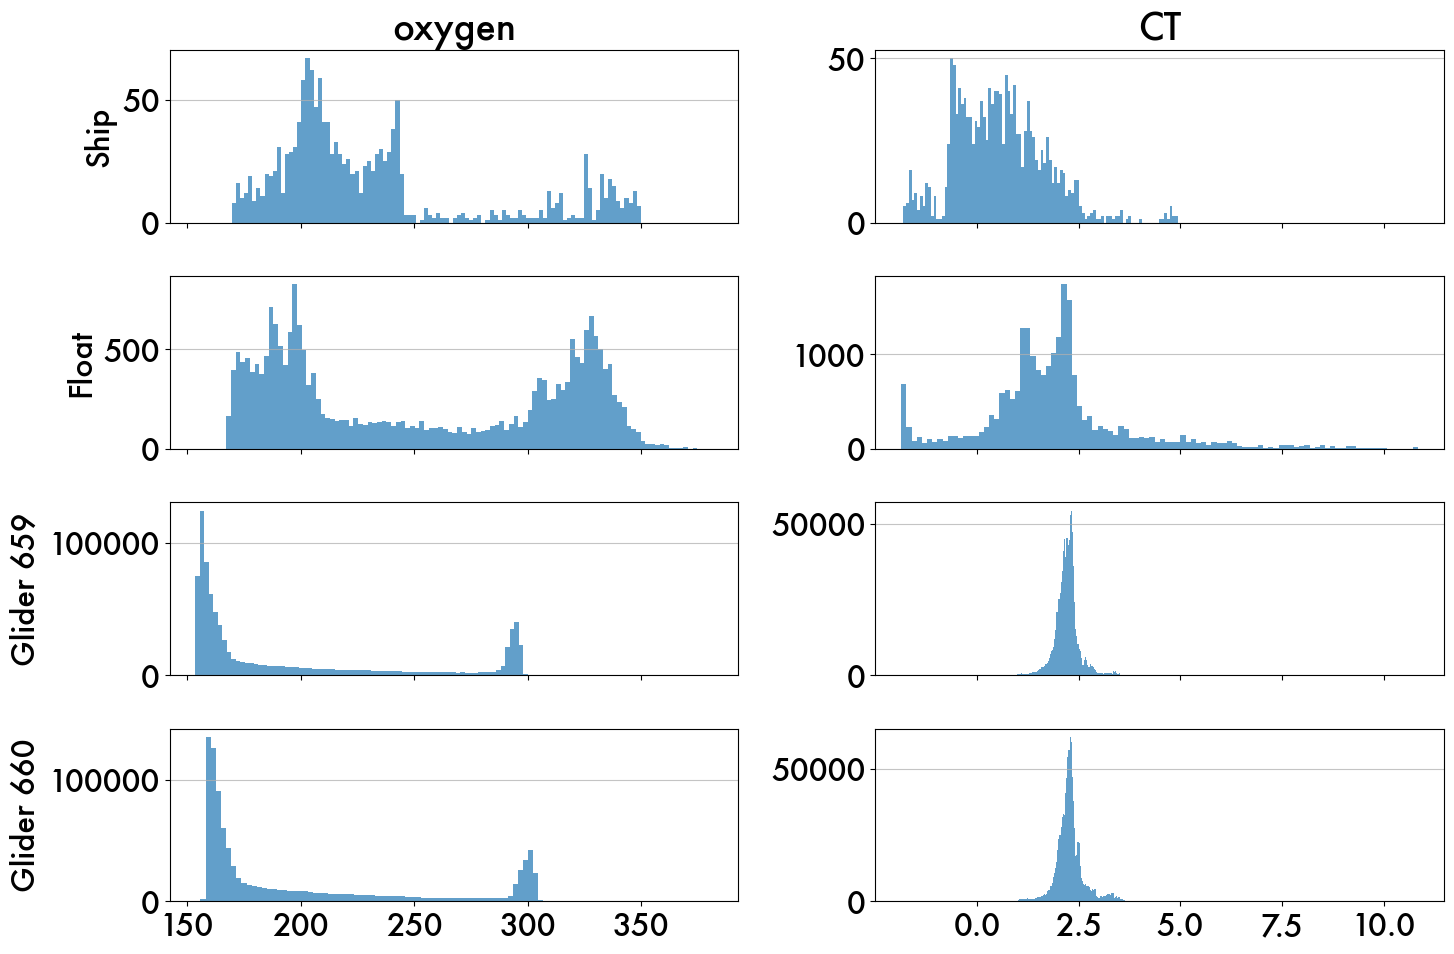

In [30]:
# Variable distributions from training ship/float data 
nbins = 100
fig, axs = plt.subplots(4, 2, figsize=(15, 10), tight_layout=True, sharex='col')
for c, var in enumerate(['oxygen', 'CT']):
    axs[0,c].hist(x=shipDF[var].values, bins=nbins, alpha=0.7)
    axs[1,c].hist(x=argo_final[var].values, bins=nbins, alpha=0.7)
    axs[2,c].hist(x=df_659[var].values, bins=nbins, alpha=0.7)
    axs[3,c].hist(x=df_660[var].values, bins=nbins, alpha=0.7)

    axs[0,c].set_title(var)

axs[0,0].set_ylabel('Ship')
axs[1,0].set_ylabel('Float')
axs[2,0].set_ylabel('Glider 659')
axs[3,0].set_ylabel('Glider 660')

for ax in axs.flatten():
    ax.grid(axis='y', alpha=0.75)

In [144]:
file_path = '../working-vars/nitrate-prediction/'
df_659 = pd.read_csv(file_path + 'RFpred_659_standard_n1000_third_0914.csv', index_col=0)
df_660 = pd.read_csv(file_path + 'RFpred_660_standard_n1000_third_0914.csv', index_col=0)

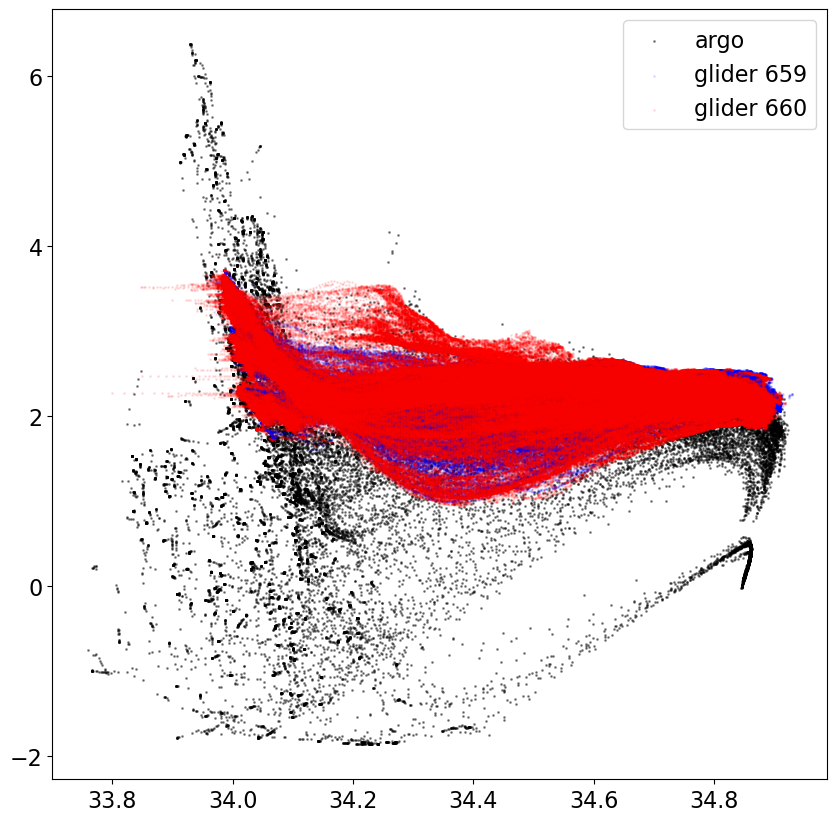

In [145]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
plt.scatter(argo_qc.SA, argo_qc.CT, c='k', alpha=0.4, s=1, label='argo')
plt.scatter(df_659.SA, df_659.CT, c='b', alpha=0.1, s=1,label='glider 659')
plt.scatter(df_660.SA, df_660.CT, c='r', alpha=0.1, s=1,label='glider 660')
plt.legend()

AttributeError: 'DataFrame' object has no attribute 'N_PROF'

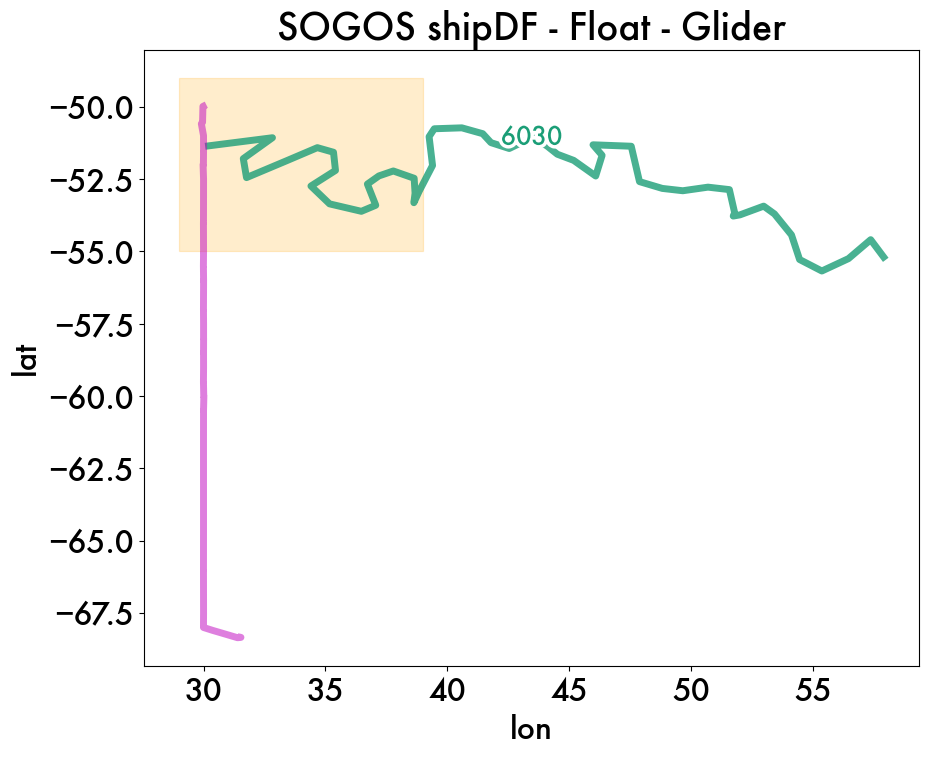

In [64]:
# Simple SOGOS -- single 6030, glider region, shipDF track

dav_659=dav_659.where(dav_659.dive<480, drop=True)
dav_660=dav_660.where(dav_660.dive<480, drop=True)
# check where floats are
fig = plt.figure(figsize=(10,8))
pal = sns.color_palette("Dark2")
sns.set_palette(pal)

# for wmo in wmo_qc:
for wmo in [5906030]:
    plt.plot(argo_data[argo_data.wmoid==wmo].lon,argo_data[argo_data.wmoid==wmo].lat, label=str(wmo)[3:], linewidth=5, alpha=0.8)
    
# plt.legend()
plt.title('SOGOS shipDF - Float - Glider')
rect = patch.Rectangle((29,-55),10,6,fill=True,color="orange", alpha=0.2,linewidth=0.9)

ax=plt.gca()
ax.add_patch(rect)
# ax.set_xlim(0,50)
ax.set_xlabel('lon')
# ax.set_ylim(-60,-30)
ax.set_ylabel('lat')

# 590603
labelLines(ax.get_lines(), align=False, fontsize=18)


# plt.scatter(shipDF.lon, shipDF.lat, c='k', s=8)
plt.plot(shipDF.lon, shipDF.lat, alpha=0.5, c='m', linewidth=5)

for nprof in shipDF.N_PROF.values[10::10]:
    plt.scatter(shipDF.lon[shipDF.N_PROF == nprof], shipDF.lat[shipDF.N_PROF == nprof], c='m', s=56)  
    plt.text(shipDF.lon[shipDF.N_PROF == nprof]+1, shipDF.lat[shipDF.N_PROF == nprof]-1, ('stn ' + str(nprof)), c='m', fontsize=18)  


plt.plot(dav_659.lon, dav_659.lat, c='k', linewidth=4)
# plt.plot(dav_660.lon, dav_660.lat, c='k', linewidth=3)

# ESPER Comparison

In [178]:
# First need to save the right dataset for import into MATLAB.
sogos_ind = np.where(argo_qc.wmoid==5906030)
df = argo_qc.iloc[sogos_ind] 

dict = {"temp": df.temperature.values, 
    "sal": df.salinity.values, 
    "oxygen": df.oxygen.values, 
    "depth": df.pressure.values,
    "lat": df.lat.values, 
    "lon": df.lon.values}

scipy.io.savemat('/Users/sangminsong/Library/CloudStorage/OneDrive-UW/Code/SOGOS-ML/working-vars/nitrate-prediction/sgfloat_for_ESPER_0601.mat', dict)
